# 01-Quantopian Research Basics

**Please remember that this notebook will only work on Quantopian! Make an account and upload this notebook file. These commands and functions won't work except on the Quantopian trading platform!**

Note a lot of the written markdown text in this notebook comes direclty from the Quantopian docs and tutorials, definitely check those out as well, they're great!

## Research

The notebook format allows us to easily gather information about variuos securities all within the Quantopian platform. Keep in mind this is different than the base coding platform of quantopian, which focuses on actually implementing and backtesting trading strategies.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# NO NEED TO DO MAGIC INLINE COMMAND ON QUANTOPIAN!

## Getting Information

Let's go over a few key functions:

* get_pricing()
* symbols()
* local_csv()
* get_backtest()
* get_fundamentals()

## get_pricing()

The `get_pricing` function provides access to 12 years of US Equity pricing data: the same data used by the Quantopian backtester.

`get_pricing` returns a <b>pandas object</b>. This could be a panel, dataframe or series depending on the input values. 

In [ ]:
mcdon = get_pricing('MCD',
                    start_date = '2017-01-01', 
                    end_date = '2017-02-01', 
                    frequency = 'minute')

In [ ]:
mcdon.head()

In [ ]:
mcdon.info()

In [ ]:
# Can only go about 12 years back
# which is really all you need for algo trading, 
# going back further probably is more noise than signal.

mcdon = get_pricing('MCD',
                    start_date = '2005-01-01', 
                    end_date = '2017-01-01', 
                    frequency = 'daily')

In [ ]:
mcdon['close_price'].plot()

In [ ]:
mcdon['close_price'].pct_change(1).hist(bins = 100,
                                        figsize = (12, 8))

## symbols()

By default `symbols` returns the security object for a ticker symbol. Specify a ticker symbol, or list of symbols, as a string and get a list of security objects back. 

- Use `symbol_reference_date` to identify which date you want the symbol back for a particular ticker symbol. 
- Specify how you would like missing results to be handled with `handle_missing`



In [ ]:
mcdon_eq_info = symbols('MCD')

In [ ]:
type(mcdon_eq_info)

In [ ]:
for key in mcdon_eq_info.to_dict():
    print(key)
    print(mcdon_eq_info.to_dict()[key])
    print('\n')

## get_fundamentals()

The `get_fundamentals` function provides programmatic access to the Quantopian fundamental database. Based on data provided by Morningstar, `get_fundamentals` provides over 600 corporate metrics dating back to 2002 (to match Quantopian's pricing data). 

The data used by this research function is the same data used by the `get_fundamentals` function used in the Quantopian IDE. The fields are described in the Quantopian help documents: http://www.quantopian.com/help/fundamentals.


In [ ]:
# Have to do this first in the notebook:
fundamentals = init_fundamentals()

The get_fundamentals() function takes in a SQLAlchemy query which can be quite complicated and strange looking at first. Basically it allows you to filter by a variety of fundamentals (things like Market Cap, P/E Ratio, or even city of HQ). Check out the link above for all the things you can filter by!

Let's walk through a few query examples.

First call fundamentals and use tab to check out the various options:

In [ ]:
#fundamentals. # call tab here as in the video!

In [ ]:
# Market Cap
my_query = query(fundamentals.valuation.market_cap)

In [ ]:
my_funds = get_fundamentals(my_query,
                            '2017-01-01')

In [ ]:
my_funds.info()

In [ ]:
# Basically just returns the market cap of everything
# for 2017-01-01
my_funds.head()

In [ ]:
# What you usualy do is filter by other qualities after the query!

# Only get companies worth 500 billion or more (that's a lot of dough!)
big_companies = (query(fundamentals.valuation.market_cap).
                 filter(fundamentals.valuation.market_cap > 500000000000) )

In [ ]:
my_big_funds = get_fundamentals(big_companies,
                                '2017-07-19')

In [ ]:
# On 
my_big_funds

In [ ]:
7.82 * 10 ** 11

In [ ]:
#get_fundamentals()

# Basic Algorithm Methods

Let's algorithmically test our earlier optimized tech portfolio strategy with Quantopian!



#### THIS CODE ONLY WORKS ON QUANTOPIAN. EACH CELL CORRESPONDS WITH A PART OF THE VIDEO LECTURE. MAKE SURE TO WATCH THE VIDEOS FOR CLARITY ON THIS!

**initialize()**

initialize() is called exactly once when our algorithm starts and requires context as input.

context is an augmented Python dictionary used for maintaining state during our backtest or live trading, and can be referenced in different parts of our algorithm. context should be used instead of global variables in the algorithm. Properties can be accessed using dot notation (context.some_property).

** handle_data() **

handle_data() is called once at the end of each minute and requires context and data as input. context is a reference to the same dictionary in initialize() and data is an object that stores several API functions.

## Our Tech Stock Optimized Portfolio

Let's use the tech stock portfolio we calculated earlier. Keep in mind that handle_data() is readjusting our portfolio every minute! That may be unreasonable for certain algorithms, but for this example, we will just continue with these basics functions.

In [ ]:
def initialize(context):
    # Reference to Tech Stocks
    context.aapl = sid(24)
    context.csco = sid(1900)
    context.amzn = sid(16841)

def handle_data(context, data):
    # Position our portfolio optimization!
    order_target_percent(context.aapl, .27)
    order_target_percent(context.csco, .20)
    order_target_percent(context.amzn, .53)

### Grabbing Current Data

### data.current()
data.current() can be used to retrieve the most recent value of a given field(s) for a given asset(s). data.current() requires two arguments: the asset or list of assets, and the field or list of fields being queried. Possible fields include 'price', 'open', 'high', 'low', 'close', and 'volume'. The output type will depend on the input types

In [ ]:
def initialize(context):
    # Reference to Tech Stocks
    context.techies = [sid(16841),
                       sid(24),
                       sid(1900)]

def handle_data(context, data):
    # Position our portfolio optimization!
    tech_close = data.current(context.techies, 'close')
    print(type(tech_close)) # Pandas Series
    print(tech_close) # Closing Prices 

##### Note! You can use data.is_stale(sid(#)) to check if the results of data.current() where generated at the current bar (the timeframe) or were forward filled from a previous time.

### Checking for trading

### data.can_trade()

data.can_trade() is used to determine if an asset(s) is currently listed on a supported exchange and can be ordered. If data.can_trade() returns True for a particular asset in a given minute bar, we are able to place an order for that asset in that minute. This is an important guard to have in our algorithm if we hand-pick the securities that we want to trade. It requires a single argument: an asset or a list of assets.

In [ ]:
def initialize(context):
    # Reference to amazn
    context.amzn = sid(16841)
    
def handle_data(context, data):
    # This insures we don't hit an exception!
    if data.can_trade(sid(16841)):
        order_target_percent(context.amzn, 1.0)

# Checking Historical Data

When your algorithm calls data.history on equities, the returned data is adjusted for splits, mergers, and dividends as of the current simulation date. In other words, when your algorithm asks for a historical window of prices, and there is a split in the middle of that window, the first part of that window will be adjusted for the split. This adustment is done so that your algorithm can do meaningful calculations using the values in the window.

This code queries the last 20 days of price history for a static set of securities. Specifically, this returns the closing daily price for the last 20 days, including the current price for the current day. Equity prices are split- and dividend-adjusted as of the current date in the simulation:

In [ ]:

def initialize(context):
    # AAPL, MSFT, and SPY
    context.assets = [sid(24), sid(1900), sid(16841)]

def before_trading_start(context,data):
    price_history = data.history(context.assets,
                                 fields = "price", 
                                 bar_count = 5, 
                                 frequency = "1d")
    
    print(price_history)


The bar_count field specifies the number of days or minutes to include in the pandas DataFrame returned by the history function. This parameter accepts only integer values.

The frequency field specifies how often the data is sampled: daily or minutely. Acceptable inputs are ‘1d’ or ‘1m’. For other frequencies, use the pandas resample function.

### Examples
Below are examples of code along with explanations of the data returned.

### Daily History

Use "1d" for the frequency. The dataframe returned is always in daily bars. The bars never span more than one trading day. For US equities, a daily bar captures the trade activity during market hours (usually 9:30am-4:00pm ET). For US futures, a daily bar captures the trade activity from 6pm-6pm ET (24 hours). For example, the Monday daily bar captures trade activity from 6pm the day before (Sunday) to 6pm on the Monday. Tuesday's daily bar will run from 6pm Monday to 6pm Tuesday, etc. For either asset class, the last bar, if partial, is built using the minutes of the current day.

### Examples (assuming context.assets exists):

* data.history(context.assets, "price", 1, "1d") returns the current price.
* data.history(context.assets, "volume", 1, "1d") returns the volume since the current day's open, even if it is partial.
* data.history(context.assets, "price", 2, "1d") returns yesterday's close price and the current price.
* data.history(context.assets, "price", 6, "1d") returns the prices for the previous 5 days and the current price.


### Minute History

Use "1m" for the frequency.

Examples (assuming context.assets exists):

* data.history(context.assets, "price", 1, "1m") returns the current price.
* data.history(context.assets, "price", 2, "1m") returns the previous minute's close price and the current price.
* data.history(context.assets, "volume", 60, "1m") returns the volume for the previous 60 minutes.

# Scheduling

Use schedule_function to indicate when you want other functions to occur. The functions passed in must take context and data as parameters.

In [ ]:
def initialize(context):
    context.appl = sid(49051)

    # At ebginning of trading week
    # At Market Open, set 10% of portfolio to be apple
    schedule_function(open_positions, 
                      date_rules.week_start(), 
                      time_rules.market_open())
    
    # At end of trading week
    # 30 min before market close, dump all apple stock.
    schedule_function(close_positions, 
                      date_rules.week_end(), 
                      time_rules.market_close(minutes = 30))

def open_positions(context, data):
    order_target_percent(context.appl, 0.10)

def close_positions(context, data):
    order_target_percent(context.appl, 0)

# Portfolio Information

You can get portfolio information and record it!

In [ ]:
def initialize(context):
    context.amzn = sid(16841)
    context.ibm = sid(3766)

    schedule_function(rebalance, 
                      date_rules.every_day(), 
                      time_rules.market_open())
    schedule_function(record_vars, 
                      date_rules.every_day(), 
                      time_rules.market_close())

def rebalance(context, data):
    # Half of our portfolio long on amazn
    order_target_percent(context.amzn, 0.50)
    # Half is shorting IBM
    order_target_percent(context.ibm, -0.50)

def record_vars(context, data):

    # Plot the counts
    record(amzn_close=data.current(context.amzn, 'close'))
    record(ibm_close=data.current(context.ibm, 'close'))

# Slippage and Commision 

### Slippage
Slippage is where a simulation estimates the impact of orders on the fill rate and execution price they receive. When an order is placed for a trade, the market is affected. Buy orders drive prices up, and sell orders drive prices down; this is generally referred to as the price_impact of a trade. Additionally, trade orders do not necessarily fill instantaneously. Fill rates are dependent on the order size and current trading volume of the ordered security. The volume_limit determines the fraction of a security's trading volume that can be used by your algorithm.

In backtesting and non-brokerage paper trading (Quantopian paper trading), a slippage model can be specified in initialize() using set_slippage(). There are different builtin slippage models that can be used, as well as the option to set a custom model. By default (if a slippage model is not specified), the following volume share slippage model is used:

In [ ]:
set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, 
                                          price_impact = 0.1))

Using the default model, if an order of 60 shares is placed for a given stock, then 1000 shares of that stock trade in each of the next several minutes and the volume_limit is 0.025, then our trade order will be split into three orders (25 shares, 25 shares, and 10 shares) that execute over the next 3 minutes.

At the end of each day, all open orders are canceled, so trading liquid stocks is generally a good idea. Additionally, orders placed exactly at market close will not have time to fill, and will be canceled.

### Commision

To set the cost of trades, we can specify a commission model in initialize() using set_commission(). By default (if a commission model is not specified), the following commission model is used:

In [ ]:
set_commission(commission.PerShare(cost = 0.0075, 
                                   min_trade_cost = 1))

The default commission model charges 0.0075 dollar per share, with a minimum trade cost of $1.

Slippage and commission models can have an impact on the performance of a backtest. The default models used by Quantopian are fairly realistic, and it is highly recommended that you use them.

# Great Job!

Those are all the basics of Quantopians Tutorial! With these key functions you actually know enough to begin trading! 

# First Trading Algorithm
## Pairs Trading

Pairs trading is a strategy that uses two stocks that are highly correlated. We can then use the difference in price between the two stocks as signal if one moves out of correlation with the other. It is an older strategy that is used classically as a guide to beginning algorithmic trading. There is a fantastic full guide and write up on Investopedia you can find [here](http://www.investopedia.com/university/guide-pairs-trading/)! **I highly recommend reading the article in full before continuing, it is entertaining and informative!**


Let's create our first basic trading algorithm! This is an exercise in using quantopian, **NOT** a realistic representation of what a good algorithm is! Never use something as simple as this in the real world! This is an extremely simplified version of Pairs Trading, we won't be considering factors such as cointegration!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import quandl

## United Airlines and American Airlines

In [ ]:
start = '07-01-2015'
end = '07-01-2017'

In [ ]:
united = quandl.get('WIKI/UAL',
                    start_date = start,
                    end_date = end)
american = quandl.get('WIKI/AAL',
                      start_date = start,
                      end_date = end)

In [ ]:
united.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2015-01-07,64.96,66.11,64.00,65.53,5133939.0,0.0,1.0,64.96,66.11,64.00,65.53,5133939.0
2015-01-08,65.70,67.52,65.41,66.64,6889597.0,0.0,1.0,65.70,67.52,65.41,66.64,6889597.0
2015-01-09,66.76,66.97,64.90,65.34,3488027.0,0.0,1.0,66.76,66.97,64.90,65.34,3488027.0
2015-01-12,66.16,66.85,63.84,65.92,5246008.0,0.0,1.0,66.16,66.85,63.84,65.92,5246008.0
2015-01-13,66.84,68.26,65.45,66.41,6265791.0,0.0,1.0,66.84,68.26,65.45,66.41,6265791.0


In [ ]:
american.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2015-01-07,53.38,53.65,52.12,53.01,10069816.0,0.0,1.0,51.996785,52.259788,50.769435,51.636372,10069816.0
2015-01-08,53.48,54.28,53.25,53.66,9672064.0,0.0,1.0,52.094194,52.873463,51.870153,52.269529,9672064.0
2015-01-09,53.67,53.91,51.82,52.02,12290046.0,0.0,1.0,52.279270,52.513051,50.477208,50.672026,12290046.0
2015-01-12,51.06,51.45,49.20,49.58,18261336.0,0.0,1.0,49.736902,50.116796,47.925100,48.295253,18261336.0
2015-01-13,50.12,51.43,49.46,50.40,12259271.0,0.0,1.0,48.821260,50.097314,48.178362,49.094004,12259271.0


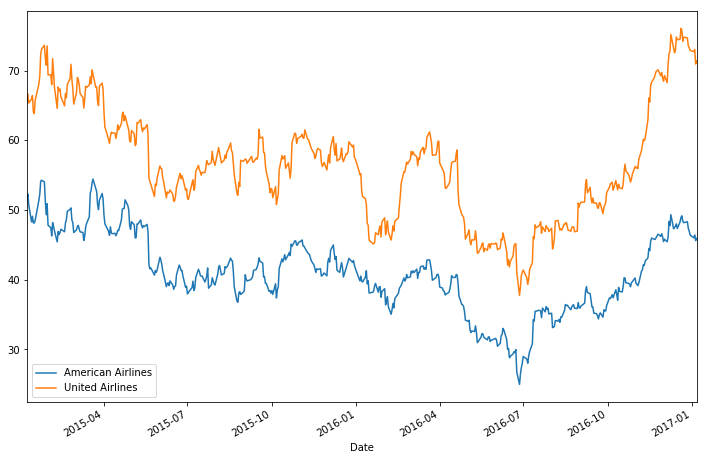

In [ ]:
american['Adj. Close'].plot(label = 'American Airlines',
                            figsize = (12, 8))
united['Adj. Close'].plot(label = 'United Airlines')
plt.legend()

## Spread and Correlation

In [ ]:
np.corrcoef(american['Adj. Close'], 
            united['Adj. Close'])

array([[ 1.        ,  0.92145101],
       [ 0.92145101,  1.        ]])

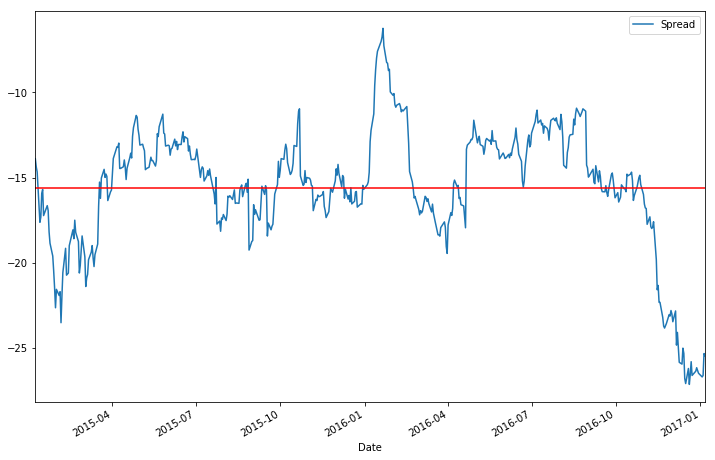

In [ ]:
spread = american['Adj. Close'] - united['Adj. Close']
spread.plot(label='Spread',
            figsize = (12,8))
plt.axhline(spread.mean(),
            c = 'r')
plt.legend()

### Normalizing with a z-score

In [ ]:
def zscore(stocks):
    return (stocks - stocks.mean()) / np.std(stocks)

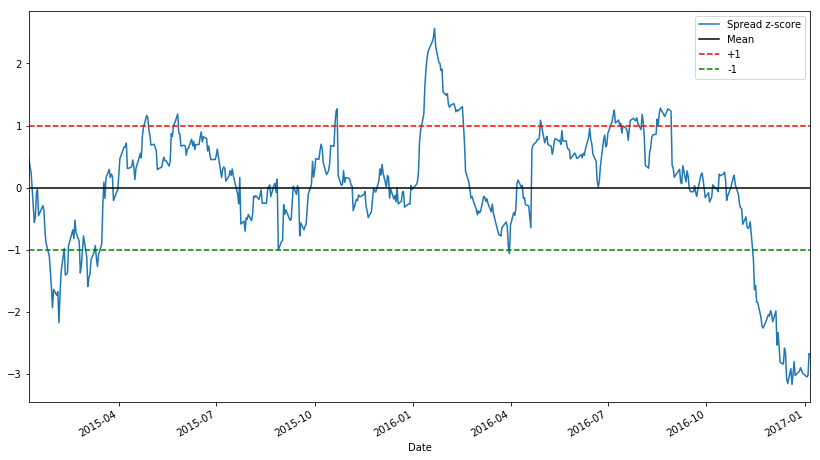

In [ ]:
zscore(spread).plot(figsize = (14,8))
plt.axhline(zscore(spread).mean(), 
            color = 'black')
plt.axhline(1.0, c = 'r', ls = '--')
plt.axhline(-1.0, c = 'g', ls = '--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

### Rolling Z-Score

Our spread is currently American-United. Let's decide how to calculate this on a rolling basis for our use in Quantopian

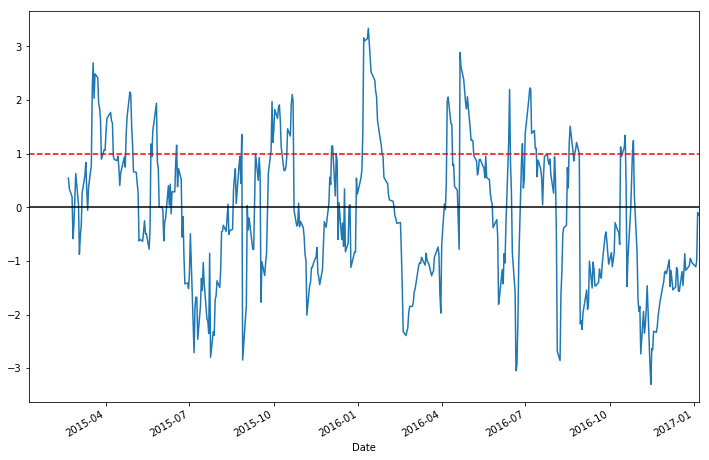

In [ ]:
#1 day moving average of the price spread
spread_mavg1 = spread.rolling(1).mean()

# 30 day moving average of the price spread
spread_mavg30 = spread.rolling(30).mean()

# Take a rolling 30 day standard deviation
std_30 = spread.rolling(30).std()

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30) / std_30



zscore_30_1.plot(figsize = (12, 8),
                 label = 'Rolling 30 day Z score')
plt.axhline(0, color = 'black')
plt.axhline(1.0, color = 'red', linestyle = '--');

## Implementation of Strategy

#### WARNING: YOU SHOULD NOT ACTUALLY TRADE WITH THIS!

In [ ]:
import numpy as np
 
def initialize(context):
    """
    Called once at the start of the algorithm.
    """   
    
    # Every day we check the pair status
    schedule_function(check_pairs, date_rules.every_day(), time_rules.market_close(minutes = 60))
    
    # Our Two Airlines
    context.aa = sid(45971) #aal
    context.ual = sid(28051) #ual   
    
    # Flags to tell us if we're currently in a trade
    context.long_on_spread = False
    context.shorting_spread = False


def check_pairs(context, data):
    
    # For convenience
    aa = context.aa
    ual = context.ual
    
    # Get pricing history
    prices = data.history([aa, ual], "price", 30, '1d')
    
 
    # Need to use .iloc[-1:] to get dataframe instead of series
    short_prices = prices.iloc[-1:]
    
    # Get the long 30 day mavg
    mavg_30 = np.mean(prices[aa] - prices[ual])
    
    # Get the std of the 30 day long window
    std_30 = np.std(prices[aa] - prices[ual])
    
    # Get the shorter span 1 day mavg
    mavg_1 = np.mean(short_prices[aa] - short_prices[ual])
    
    # Compute z-score
    if std_30 > 0:
        zscore = (mavg_1 - mavg_30)/std_30
    
        # Our two entry cases
        if zscore > 0.5 and not context.shorting_spread:
            # spread = aa - ual
            order_target_percent(aa, -0.5) # short top
            order_target_percent(ual, 0.5) # long bottom
            context.shorting_spread = True
            context.long_on_spread = False
            
        elif zscore < -0.5 and not context.long_on_spread:
            # spread = aa - ual
            order_target_percent(aa, 0.5) # long top
            order_target_percent(ual, -0.5) # short bottom
            context.shorting_spread = False
            context.long_on_spread = True
            
        # Our exit case
        elif abs(zscore) < 0.1:
            order_target_percent(aa, 0)
            order_target_percent(ual, 0)
            context.shorting_spread = False
            context.long_on_spread = False
        
        record('zscore', zscore)

# Trading Algorithm Exercise 
** This is an extremely open exercise and there are lots of ways to do it! Please feel free to just skip to the solutions to treat it as an example code along. If you attempt the exercise, do not expect the example solution to exactly match up to your solution. You may have performed much better (or much worse)! **

## Your Task

Your manager wants to see if [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands) are still a meaningful technical analysis strategy on their own. For this exercise, you will be testing *Johnson and Johnson* sid(4151).Specifically, your manager has decided he wants set 100% of the portfolio to go long when the stock price is below 2 times the 20 day rolling standard deviation subtracted from the 20 day moving average, and go 100% short of the portfolio on that stock when the current price is above 2 times the 20 day rolling standard deviation added on to the 20 day moving average. The check for this signal event should only happen once per day. This is probably a very unreasonable strategy, but the main point of this is to exercise your ability to write out backtest algorithms with Quantopian.

## Time Frame

You should use the following time frame for this exercise (so you can at least have a reasonable comparison to the solutions, but feel free to play around with this!)

#### BACKTEST START:  Jul-20-2014
#### BACKTEST END: Jul-20-2017

# Trading Algorithm Exercise Solutions

** This is an extremely open exercise and there are lots of ways to do it! Please feel free to just skip to the solutions to treat it as an example code along. If you attempt the exercise, do not expect the example solution to exactly match up to your solution. You may have performed much better (or much worse)! **

## Your Task

Your manager wants to see if [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands) are still a meaningful technical analysis strategy on their own. For this exercise, you will be testing *Johnson and Johnson* sid(4151).Specifically, your manager has decided he wants set 100% of the portfolio to go long when the stock price is below 2 times the 20 day rolling standard deviation subtracted from the 20 day moving average, and go 100% short of the portfolio on that stock when the current price is above 2 times the 20 day rolling standard deviation added on to the 20 day moving average. The check for this signal event should only happen once per day. This is probably a very unreasonable strategy, but the main point of this is to exercise your ability to write out backtest algorithms with Quantopian.

## Time Frame

You should use the following time frame for this exercise (so you can at least have a reasonable comparison to the solutions, but feel free to play around with this!)

#### BACKTEST START:  Jul-20-2014
#### BACKTEST END: Jul-20-2017

In [ ]:
# Setup our variables
def initialize(context):
    context.jj = sid(4151)

    schedule_function(check_bands, date_rules.every_day())
        
def check_bands(context, data):
    
    cur_price = data.current(context.jj, 'price')
    
    # Load historical data for the stocks
    prices = data.history(context.jj, 'price', 20 , '1d')
    
    avg = prices.mean()
    std = prices.std()
    lower_band = avg - 2 * std
    upper_band = avg + 2 * std
    
    if cur_price <= lower_band:
        order_target_percent(context.jj, 1.0)
        print('Buying')
        print('Current price is: ' + str(cur_price))
        print("Lower band is: "+str(lower_band))
        
        
    elif cur_price >= upper_band:
        order_target_percent(context.jj, -1.0)
        print('Shorting')
        print('Current price is: ' + str(cur_price))
        print("Upper band is: "+str(upper_band))
    else:
        pass
        
    record(upper = upper_band,
           lower = lower_band,
           mvag_20 = avg,
           price = cur_price)

# Pipeline

This notebook is from the official Quantopian Guide on Pipelines. Make sure to visit their documentation for many more great resources!

Many trading algorithms have the following structure:

1. For each asset in a known (large) set, compute N scalar values for the asset based on a trailing window of data.
2. Select a smaller tradeable set of assets based on the values computed in (1).
3. Calculate desired portfolio weights on the set of assets selected in (2).
4. Place orders to move the algorithm’s current portfolio allocations to the desired weights computed in (3).

There are several technical challenges with doing this robustly. These include:

* efficiently querying large sets of assets
* performing computations on large sets of assets
* handling adjustments (splits and dividends)
* asset delistings

Pipeline exists to solve these challenges by providing a uniform API for expressing computations on a diverse collection of datasets.

## Factors
A factor is a function from an asset and a moment in time to a numerical value.

A simple example of a factor is the most recent price of a security. Given a security and a specific point in time, the most recent price is a number. Another example is the 10-day average trading volume of a security. Factors are most commonly used to assign values to securities which can then be used in a number of ways. A factor can be used in each of the following procedures:
* computing target weights
* generating alpha signal
* constructing other, more complex factors
* constructing filters

## Filters
A filter is a function from an asset and a moment in time to a boolean.
An example of a filter is a function indicating whether a security's price is below $10. Given a security and a point in time, this evaluates to either True or False. Filters are most commonly used for describing sets of assets to include or exclude for some particular purpose.

## Classifiers
A classifier is a function from an asset and a moment in time to a categorical output.
More specifically, a classifier produces a string or an int that doesn't represent a numerical value (e.g. an integer label such as a sector code). Classifiers are most commonly used for grouping assets for complex transformations on Factor outputs. An example of a classifier is the exchange on which an asset is currently being traded.

In [ ]:
from quantopian.pipeline import Pipeline

In [ ]:
def make_pipeline():
    return Pipeline()

In [ ]:
pipe = make_pipeline()

In [ ]:
from quantopian.research import run_pipeline

In [ ]:
result = run_pipeline(pipe, '2017-01-01', '2017-01-01')

In [ ]:
result.head(10)

In [ ]:
result.info()

# Data

In [ ]:
from quantopian.pipeline.data.builtin import USEquityPricing

## Factors

Remember, Factors take in an asset and a timestamp and return some numerical value.

In [ ]:
from quantopian.pipeline.factors import BollingerBands,SimpleMovingAverage,EWMA

In [ ]:
SimpleMovingAverage(inputs = [USEquityPricing.close],
                    window_length = 30)

In [ ]:
def make_pipeline():
    
    mean_close_30 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 30)
    
    return Pipeline(columns = {
        '30 Day Mean Close':mean_close_30
    })

In [ ]:
results = run_pipeline(make_pipeline(),
                       '2017-01-01',
                       '2017-01-01')

In [ ]:
results.head(20)

In [ ]:
def make_pipeline():
    
    mean_close_30 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 30)
    latest_close = USEquityPricing.close.latest
    
    return Pipeline(columns = {
        '30 Day Mean Close':mean_close_30,
        'Latest Close':latest_close
    })

In [ ]:
results = run_pipeline(make_pipeline(),
                       '2017-01-01',
                       '2017-01-01')

In [ ]:
results.head(10)

## Combining Factors

In [ ]:
def make_pipeline():
    
    mean_close_10 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 10)
    mean_close_30 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 30)
    latest_close = USEquityPricing.close.latest
    
    percent_difference = (mean_close_10-mean_close_30) / mean_close_30
    
    return Pipeline(columns = {
        'Percent Difference':percent_difference,
        '30 Day Mean Close':mean_close_30,
        'Latest Close':latest_close
    })

In [ ]:
results = run_pipeline(make_pipeline(),
                       '2017-01-01',
                       '2017-01-01')

In [ ]:
results.head()

# Filters and Screens

Filters take in an asset and a timestamp and return a boolean

In [ ]:
last_close_price = USEquityPricing.close.latest
close_price_filter = last_close_price > 20

In [ ]:
close_price_filter

In [ ]:
def make_pipeline():
    
    mean_close_10 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 10)
    mean_close_30 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 30)
    latest_close = USEquityPricing.close.latest
    
    percent_difference = (mean_close_10-mean_close_30) / mean_close_30
    
    perc_diff_check = percent_difference > 0 
    
    return Pipeline(columns = {
        'Percent Difference':percent_difference,
        '30 Day Mean Close':mean_close_30,
        'Latest Close':latest_close,
        'Positive Percent Diff': perc_diff_check
    })

In [ ]:
results = run_pipeline(make_pipeline(),
                       '2017-01-01',
                       '2017-01-01')
results.head()

## Screens

In [ ]:
def make_pipeline():
    
    mean_close_10 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 10)
    mean_close_30 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 30)
    latest_close = USEquityPricing.close.latest
    
    percent_difference = (mean_close_10-mean_close_30) / mean_close_30
    
    perc_diff_check = percent_difference > 0 
    
    return Pipeline(columns = {
                            'Percent Difference':percent_difference,
                            '30 Day Mean Close':mean_close_30,
                            'Latest Close':latest_close,
                            'Positive Percent Diff': perc_diff_check},
                    screen=perc_diff_check)

In [ ]:
results = run_pipeline(make_pipeline(),
                       '2017-01-01',
                       '2017-01-01')
results.head()

### Reverse a screen

In [ ]:
def make_pipeline():
    
    mean_close_10 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 10)
    mean_close_30 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 30)
    latest_close = USEquityPricing.close.latest
    
    percent_difference = (mean_close_10-mean_close_30) / mean_close_30
    
    perc_diff_check = percent_difference > 0 
    
    return Pipeline(columns = {
                            'Percent Difference':percent_difference,
                            '30 Day Mean Close':mean_close_30,
                            'Latest Close':latest_close,
                            'Positive Percent Diff': perc_diff_check},
                    screen = ~perc_diff_check)

In [ ]:
results = run_pipeline(make_pipeline(),
                       '2017-01-01',
                       '2017-01-01')
results.head()

## Combine Filters

In [ ]:
def make_pipeline():
    
    mean_close_10 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 10)
    mean_close_30 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 30)
    latest_close = USEquityPricing.close.latest
    
    percent_difference = (mean_close_10-mean_close_30) / mean_close_30
    
    perc_diff_check = percent_difference > 0 
    small_price = latest_close < 5
    
    final_filter = perc_diff_check & small_price
    
    return Pipeline(columns = {
                            'Percent Difference':percent_difference,
                            '30 Day Mean Close':mean_close_30,
                            'Latest Close':latest_close,
                            'Positive Percent Diff': perc_diff_check},
                    screen = final_filter)

In [ ]:
results = run_pipeline(make_pipeline(),
                       '2017-01-01',
                       '2017-01-01')
results.head()

# Masking

Sometimes we want to ignore certain assets when computing pipeline expresssions. There are two common cases where ignoring assets is useful:
* We want to compute an expression that's computationally expensive, and we know we only care about results for certain assets.
* We want to compute an expression that performs comparisons between assets, but we only want those comparisons to be performed against a subset of all assets. 

In [ ]:
def make_pipeline():
    
    # Create Filters for Masks First
    latest_close = USEquityPricing.close.latest
    small_price = latest_close < 5
    
    # Pass in the mask
    mean_close_10 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 10,
                                        mask = small_price)
    mean_close_30 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 30,
                                        mask = small_price)
    
    
    percent_difference = (mean_close_10-mean_close_30) / mean_close_30
    
    perc_diff_check = percent_difference > 0 
    
    
    final_filter = perc_diff_check
    
    return Pipeline(columns = {
                            'Percent Difference':percent_difference,
                            '30 Day Mean Close':mean_close_30,
                            'Latest Close':latest_close,
                            'Positive Percent Diff': perc_diff_check},
                    screen = final_filter)

In [ ]:
results = run_pipeline(make_pipeline(),
                       '2017-01-01',
                       '2017-01-01')
results.head()

In [ ]:
len(results)

# Classifiers

A classifier is a function from an asset and a moment in time to a categorical output such as a string or integer label.

In [ ]:
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.classifiers.morningstar import Sector

In [ ]:
morningstar_sector = Sector()

In [ ]:
exchange = morningstar.share_class_reference.exchange_id.latest

In [ ]:
exchange

### Classifier Methods

* eq (equals)
* isnull
* startswith

In [ ]:
nyse_filter = exchange.eq('NYS')

In [ ]:
def make_pipeline():
    
    # Create Filters for Masks First
    latest_close = USEquityPricing.close.latest
    small_price = latest_close < 5
    
    # Classifier
    nyse_filter = exchange.eq('NYS')
    
    # Pass in the mask
    mean_close_10 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 10,
                                        mask = small_price)
    mean_close_30 = SimpleMovingAverage(inputs = [USEquityPricing.close],
                                        window_length = 30,
                                        mask = small_price)
    
    
    percent_difference = (mean_close_10-mean_close_30) / mean_close_30
    
    perc_diff_check = percent_difference > 0 
    
    
    final_filter = perc_diff_check & nyse_filter
    
    return Pipeline(columns = {
                            'Percent Difference':percent_difference,
                            '30 Day Mean Close':mean_close_30,
                            'Latest Close':latest_close,
                            'Positive Percent Diff': perc_diff_check},
                    screen=final_filter)

In [ ]:
results = run_pipeline(make_pipeline(),
                       '2017-01-01',
                       '2017-01-01')
results.head()

In [ ]:
len(results)

# Pipelines in Quantopian IDE

In [ ]:
from quantopian.pipeline import Pipeline
from quantopian.algorithm import attach_pipeline, pipeline_output

def initialize(context):
    my_pipe = make_pipeline()
    attach_pipeline(my_pipe, 'my_pipeline')

def make_pipeline():
    return Pipeline()

def before_trading_start(context, data):
    # Store our pipeline output DataFrame in context.
    context.output = pipeline_output('my_pipeline')

# Pipeline Example

In [ ]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.data.builtin import USEquityPricing

## Getting the Securities we want.

### The Q500US and Q1500US

These gropus of tradeable stocks are refered to as "universes", because all your trades will use these stocks as their "Universe" of available stock, they won't be trading with anything outside these groups.

In [ ]:
from quantopian.pipeline.filters import Q1500US

There are two main benefits of the Q500US and Q1500US. Firstly, they greatly reduce the risk of an order not being filled. Secondly, they allow for more meaningful comparisons between strategies as now they will be used as the standard universes for algorithms.

In [ ]:
universe = Q1500US()

## Filtering the universe further with Classifiers

Let's only grab stocks in the energy sector: https://www.quantopian.com/help/fundamentals#industry-sector

In [ ]:
from quantopian.pipeline.data import morningstar

In [ ]:
sector = morningstar.asset_classification.morningstar_sector_code.latest

Alternative:

In [ ]:
#from quantopian.pipeline.classifiers.morningstar import Sector
#morningstar_sector = Sector()

In [ ]:
energy_sector = sector.eq(309)

## Masking Filters

Masks can be also be applied to methods that return filters like top, bottom, and percentile_between.

Masks are most useful when we want to apply a filter in the earlier steps of a combined computation. For example, suppose we want to get the 50 securities with the highest open price that are also in the top 10% of dollar volume. 

Suppose that we then want the 90th-100th percentile of these securities by close price. We can do this with the following:

In [ ]:
from quantopian.pipeline.factors import SimpleMovingAverage, AverageDollarVolume

In [ ]:
# Dollar volume factor
dollar_volume = AverageDollarVolume(window_length = 30)

# High dollar volume filter
high_dollar_volume = dollar_volume.percentile_between(90, 100)

# Top open price filter (high dollar volume securities)
top_open_price = USEquityPricing.open.latest.top(50, 
                                                 mask = high_dollar_volume)

# Top percentile close price filter (high dollar volume, top 50 open price)
high_close_price = USEquityPricing.close.latest.percentile_between(90, 100, 
                                                                   mask = top_open_price)

## Applying Filters and Factors

Let's apply our own filters, following along with some of the examples above. Let's select the following securities:

* Stocks in Q1500US
* Stocks that are in the energy Sector
* They must be relatively highly traded stocks in the market (by dollar volume traded, need to be in the top 5% traded)

Then we'll calculate the percent difference as we've done previously. Using this percent difference we'll create an unsophisticated strategy that shorts anything with negative percent difference (the difference between the 10 day mean and the 30 day mean).

In [ ]:
def make_pipeline():
    
    # Base universe filter.
    base_universe = Q1500US()
    
    # Sector Classifier as Filter
    energy_sector = sector.eq(309)
    
    # Masking Base Energy Stocks
    base_energy = base_universe & energy_sector
    
    # Dollar volume factor
    dollar_volume = AverageDollarVolume(window_length = 30)

    # Top half of dollar volume filter
    high_dollar_volume = dollar_volume.percentile_between(95, 100)
    
    # Final Filter Mask
    top_half_base_energy = base_energy & high_dollar_volume
    
    # 10-day close price average.
    mean_10 = SimpleMovingAverage(inputs=[USEquityPricing.close], 
                                  window_length = 10, 
                                  mask = top_half_base_energy)

    # 30-day close price average.
    mean_30 = SimpleMovingAverage(inputs=[USEquityPricing.close], 
                                  window_length = 30, 
                                  mask = top_half_base_energy)

    # Percent difference factor.
    percent_difference = (mean_10 - mean_30) / mean_30
    
    # Create a filter to select securities to short.
    shorts = percent_difference < 0
    
    # Create a filter to select securities to long.
    longs = percent_difference > 0
    
    # Filter for the securities that we want to trade.
    securities_to_trade = (shorts | longs)
    
    return Pipeline(
        columns = {
            'longs': longs,
            'shorts': shorts,
            'percent_diff':percent_difference
        },
        screen=securities_to_trade
    )

In [ ]:
result = run_pipeline(make_pipeline(), '2015-05-05', '2015-05-05')
result

longs  percent_diff shorts
2015-05-05 00:00:00+00:00 Equity(216 [HES])     True      0.036528  False
                          Equity(448 [APA])     True      0.035926  False
                          Equity(455 [APC])     True      0.049153  False
                          Equity(858 [BHI])     True      0.033807  False
                          Equity(1746 [COG])    True      0.058078  False
                          Equity(2368 [DVN])    True      0.046264  False
                          Equity(2564 [EOG])    True      0.032102  False
                          Equity(2621 [ESV])    True      0.060197  False
                          Equity(3443 [HAL])    True      0.049257  False
                          Equity(3647 [HP])     True      0.040991  False
                          Equity(5035 [MRO])    True      0.061598  False
                          Equity(5213 [NBL])    True      0.010443  False
                          Equity(5214 [NBR])    True      0.064133  False
                          Equity(5249 [NE])     True      0.037559  False
                          Equity(5729 [OXY])    True      0.029776  False
                          Equity(6928 [SLB])    True      0.046555  False
                          Equity(7244 [SWN])    True      0.070788  False
                          Equity(7612 [ANDV])   True      0.005997  False
                          Equity(7990 [VLO])   False     -0.017145   True
                          Equity(8214 [WMB])    True      0.018876  False
                          Equity(8347 [XOM])    True      0.017343  False
                          Equity(8461 [CHK])    True      0.014265  False
                          Equity(9038 [RIG])    True      0.048180  False
                          Equity(13176 [CAM])   True      0.082110  False
                          Equity(17436 [PXD])   True      0.010248  False
                          Equity(19249 [RRC])   True      0.087062  False
                          Equity(19336 [WFT])   True      0.049141  False
                          Equity(22784 [FTI])   True      0.054529  False
                          Equity(23112 [CVX])   True      0.018972  False
                          Equity(23998 [COP])   True      0.023902  False
                          Equity(24809 [NOV])   True      0.024940  False
                          Equity(25707 [WLL])   True      0.048205  False
                          Equity(33856 [CLR])   True      0.064304  False
                          Equity(34440 [CXO])   True      0.042184  False
                          Equity(39797 [OAS])   True      0.042388  False
                          Equity(40852 [KMI])   True      0.023016  False
                          Equity(41636 [MPC])   True      0.011952  False
                          Equity(42788 [PSX])   True      0.020911  False

In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 38 entries, (2015-05-05 00:00:00+00:00, Equity(216 [HES])) to (2015-05-05 00:00:00+00:00, Equity(42788 [PSX]))
Data columns (total 3 columns):
longs           38 non-null bool
percent_diff    38 non-null float64
shorts          38 non-null bool
dtypes: bool(2), float64(1)
memory usage: 684.0+ bytes


# Executing this Strategy in the IDE

In [ ]:
from quantopian.algorithm import attach_pipeline,pipeline_output
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import AverageDollarVolume,SimpleMovingAverage
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline.data import morningstar

def initialize(context):
    
    schedule_function(my_rebalance,date_rules.week_start(),time_rules.market_open(hours = 1))
    
    my_pipe = make_pipeline()
    attach_pipeline(my_pipe, 'my_pipeline')
    
def my_rebalance(context,data):
    for security in context.portfolio.positions:
        if security not in context.longs and security not in context.shorts and data.can_trade(security):
            order_target_percent(security,0)
            
    for security in context.longs:
        if data.can_trade(security):
            order_target_percent(security,context.long_weight)

    for security in context.shorts:
        if data.can_trade(security):
            order_target_percent(security,context.short_weight)




def my_compute_weights(context):
    
    if len(context.longs) == 0:
        long_weight = 0
    else:
        long_weight = 0.5 / len(context.longs)
  
    if len(context.shorts) == 0:
        short_weight = 0
    else:
        short_weight = 0.5 / len(context.shorts)
    
    return (long_weight,short_weight)






def before_trading_start(context,data):
    context.output = pipeline_output('my_pipeline')
    
    # LONG
    context.longs = context.output[context.output['longs']].index.tolist()
    
    # SHORT
    context.shorts = context.output[context.output['shorts']].index.tolist()


    context.long_weight,context.short_weight = my_compute_weights(context)



def make_pipeline():
    
    # Universe Q1500US
    base_universe = Q1500US()
    
    # Energy Sector
    sector = morningstar.asset_classification.morningstar_sector_code.latest
    energy_sector = sector.eq(309)
    
    # Make Mask of 1500US and Energy
    base_energy = base_universe & energy_sector
    
    # Dollar Volume (30 Days) Grab the Info
    dollar_volume = AverageDollarVolume(window_length = 30)
    
    # Grab the top 5% in avg dollar volume
    high_dollar_volume = dollar_volume.percentile_between(95, 100)
     
    # Combine the filters
    top_five_base_energy = base_energy & high_dollar_volume
    
    # 10 day mean close
    mean_10 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length = 10, mask = top_five_base_energy)
    
    # 30 day mean close
    mean_30 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length = 30, mask = top_five_base_energy)
    
    # Percent Difference
    percent_difference = (mean_10-mean_30)/mean_30
    
    # List of Shorts
    shorts = percent_difference < 0
    
    # List of Longs
    longs = percent_difference > 0
    
    # Final Mask/Filter for anything in shorts or longs
    securities_to_trade = (shorts | longs)
    
    # Return Pipeline
    return Pipeline(columns={
        'longs':longs,
        'shorts':shorts,
        'perc_diff':percent_difference
    },screen=securities_to_trade)

# Leverage

Make sure to watch the video and slides for this lecture for the full explanation!

$ Leverage Ratio = \frac{Debt + Capital Base}{Capital Base}$

## Leverage from Algorithm

Make sure to watch the video for this! Basically run this and grab your own backtestid as shown in the video. More info:

The get_backtest function provides programmatic access to the results of backtests run on the Quantopian platform. It takes a single parameter, the ID of a backtest for which results are desired.

You can find the ID of a backtest in the URL of its full results page, which will be of the form:

https://www.quantopian.com/algorithms/<algorithm_id>/<backtest_id>.  

You are only entitled to view the backtests that either:

* 1) you have created
* 2) you are a collaborator on

In [ ]:
def initialize(context):
    context.amzn = sid(16841)
    context.ibm = sid(3766)
    
    schedule_function(rebalance, 
                      date_rules.every_day(), 
                      time_rules.market_open())
    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())
    
def rebalance(context,data):
    order_target_percent(context.amzn, 0.5)
    order_target_percent(context.ibm, -0.5)
    
def record_vars(context,data):
    record(amzn_close=data.current(context.amzn, 'close'))
    record(ibm_close=data.current(context.ibm, 'close'))
    record(Leverage = context.account.leverage)
    record(Exposure = context.account.net_leverage)

## Backtest Info

In [ ]:
bt = get_backtest('5986b969dbab994fa4264696')

100% Time: 0:00:00|###########################################################|


In [ ]:
bt.algo_id

'5986b969dbab994fa4264696'

In [ ]:
bt.recorded_vars

,Exposure,Leverage,amzn_close,ibm_close
2016-07-26 00:00:00+00:00,-0.002203,0.992140,735.430,161.990
2016-07-27 00:00:00+00:00,-0.000207,0.997486,736.090,161.840
2016-07-28 00:00:00+00:00,0.006717,0.998964,752.630,161.440
2016-07-29 00:00:00+00:00,0.000162,0.996444,760.120,160.770
2016-08-01 00:00:00+00:00,0.002431,1.003876,767.755,161.320
2016-08-02 00:00:00+00:00,0.000207,0.995943,760.640,160.510
2016-08-03 00:00:00+00:00,-0.004409,1.003540,753.460,160.600
2016-08-04 00:00:00+00:00,0.003457,1.001679,760.960,161.410
2016-08-05 00:00:00+00:00,-0.002347,1.008046,765.890,163.450
2016-08-08 00:00:00+00:00,0.003158,0.995528,766.360,162.050


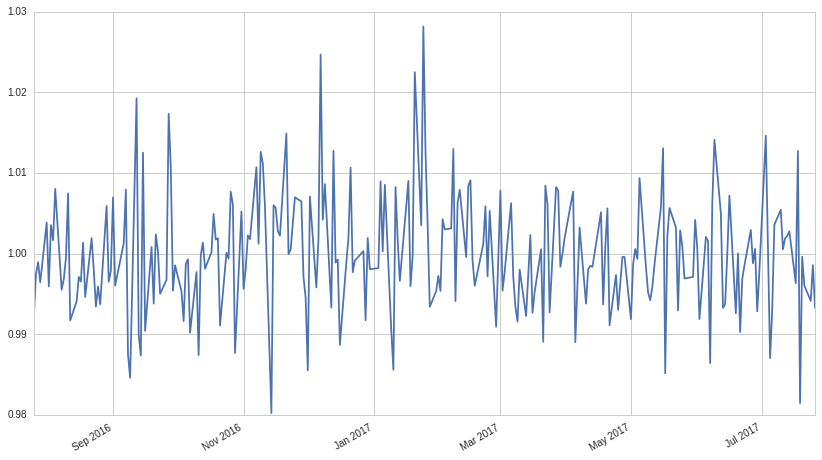

In [ ]:
bt.recorded_vars['Leverage'].plot()

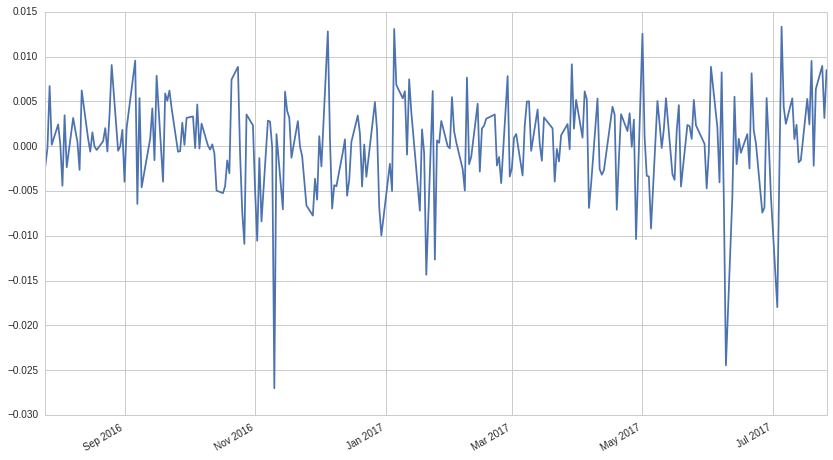

In [ ]:
bt.recorded_vars['Exposure'].plot()

##  High Leverage Example

You can actually specify to borrow on margin (NOT RECOMMENDED)

In [ ]:
def initialize(context):
    context.amzn = sid(16841)
    context.ibm = sid(3766)
    
    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open())
    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())
    
def rebalance(context,data):
    order_target_percent(context.ibm, -2.0)
    order_target_percent(context.amzn, 2.0)
    
def record_vars(context,data):
    record(amzn_close=data.current(context.amzn, 'close'))
    record(ibm_close=data.current(context.ibm, 'close'))
    record(Leverage = context.account.leverage)
    record(Exposure = context.account.net_leverage)

In [ ]:
bt = get_backtest('5986bd68ceda5554428a005b')

100% Time: 0:00:00|###########################################################|


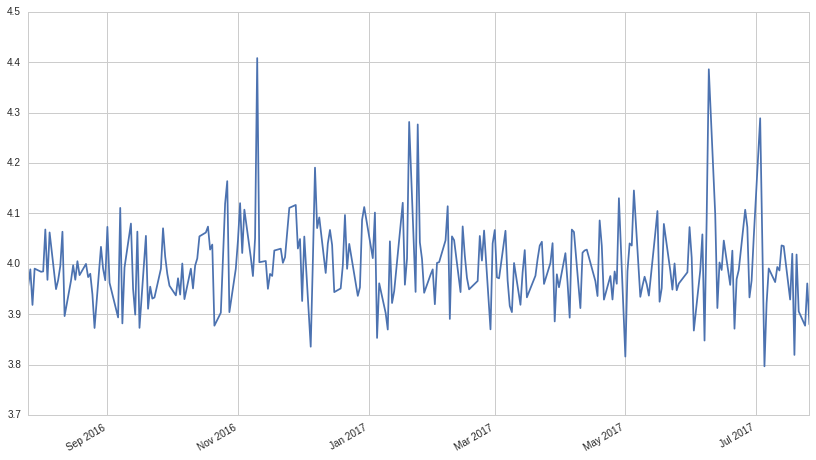

In [ ]:
bt.recorded_vars['Leverage'].plot()

## Set Hard Limit on Leverage

http://www.zipline.io/appendix.html?highlight=leverage#zipline.api.set_max_leverage

In [ ]:
def initialize(context):
    context.amzn = sid(16841)
    context.ibm = sid(3766)
    
    set_max_leverage(1.03)
    
    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open())
    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())
    
def rebalance(context,data):
    order_target_percent(context.ibm, -0.5)
    order_target_percent(context.amzn, 0.5)
    
def record_vars(context,data):
    record(amzn_close=data.current(context.amzn,'close'))
    record(ibm_close=data.current(context.ibm,'close'))
    record(Leverage = context.account.leverage)
    record(Exposure = context.account.net_leverage)

# Hedging

Make sure to refer to the video for full explanations!

In [ ]:
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
# Get data for the specified period and stocks
start = '2016-01-01'
end = '2017-01-01'
asset = get_pricing('AAPL', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end)

In [ ]:
asset_ret = asset.pct_change()[1:]
bench_ret = benchmark.pct_change()[1:]

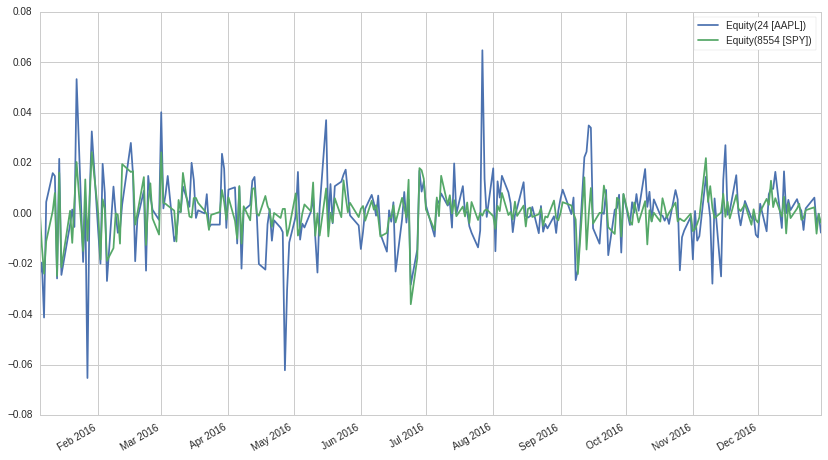

In [ ]:
asset_ret.plot()
bench_ret.plot()
plt.legend()

## Regression for Alpha and Beta Values

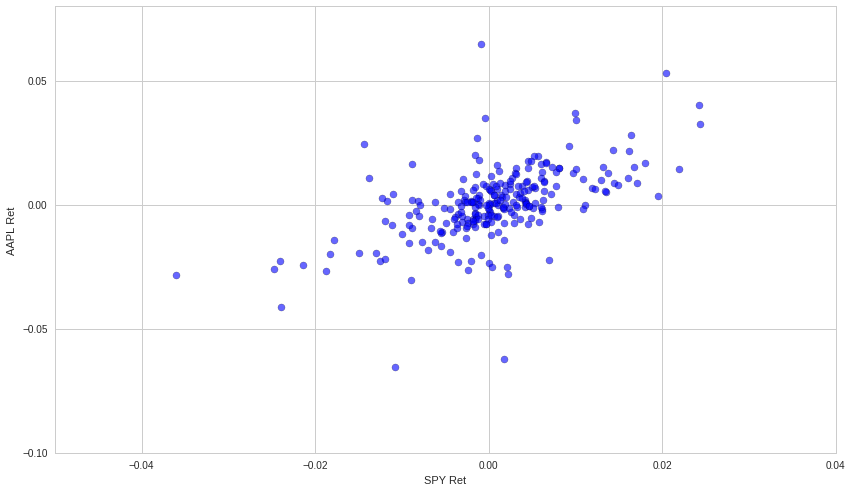

In [ ]:
plt.scatter(bench_ret,asset_ret,alpha=0.6,s=50)
plt.xlabel('SPY Ret')
plt.ylabel('AAPL Ret')

In [ ]:
AAPL = asset_ret.values
spy = bench_ret.values

In [ ]:
# Add a constant (column of 1s for intercept)
spy_constant = sm.add_constant(spy)

# Fit regression to data
model = regression.linear_model.OLS(AAPL,spy_constant).fit()

In [ ]:
model.params

array([  1.67990248e-05,   1.02981370e+00])

In [ ]:
alpha , beta = model.params

In [ ]:
alpha

1.6799024809993564e-05

In [ ]:
beta

1.0298136979465768

### Plot Alpha and Beta

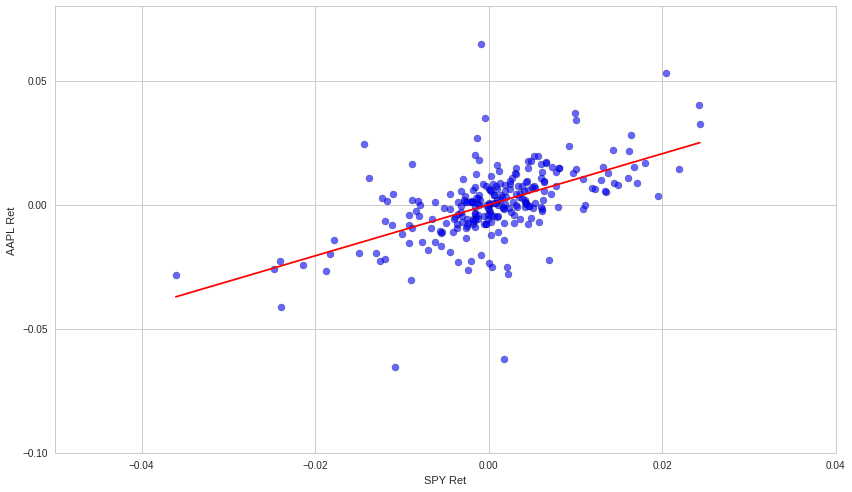

In [ ]:
# Scatter Returns
plt.scatter(bench_ret,asset_ret,alpha=0.6,s=50)

# Fit Line
min_spy = bench_ret.values.min()
max_spy = bench_ret.values.max()

spy_line = np.linspace(min_spy,max_spy,100)
y = spy_line * beta + alpha

plt.plot(spy_line,y,'r')

plt.xlabel('SPY Ret')
plt.ylabel('AAPL Ret')

## Implementing the Hedge

In [ ]:
hedged = -1*beta*bench_ret + asset_ret

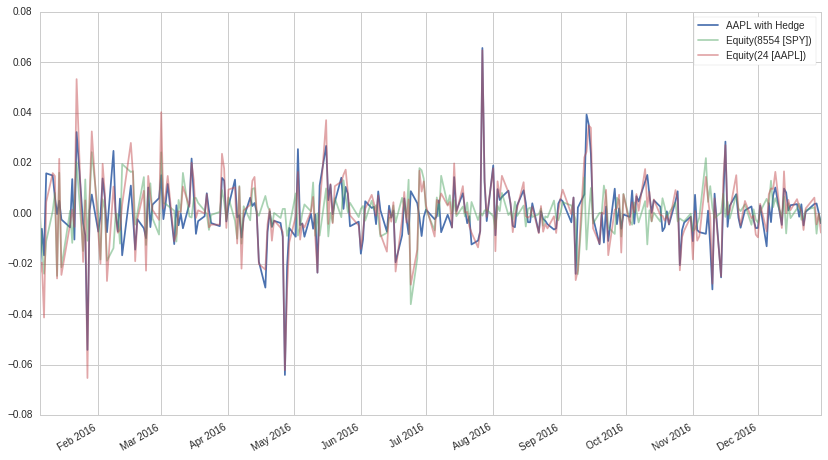

In [ ]:
hedged.plot(label='AAPL with Hedge')
bench_ret.plot(alpha=0.5)
asset_ret.plot(alpha=0.5)
plt.legend()

#### What happens if there is a big market drop?

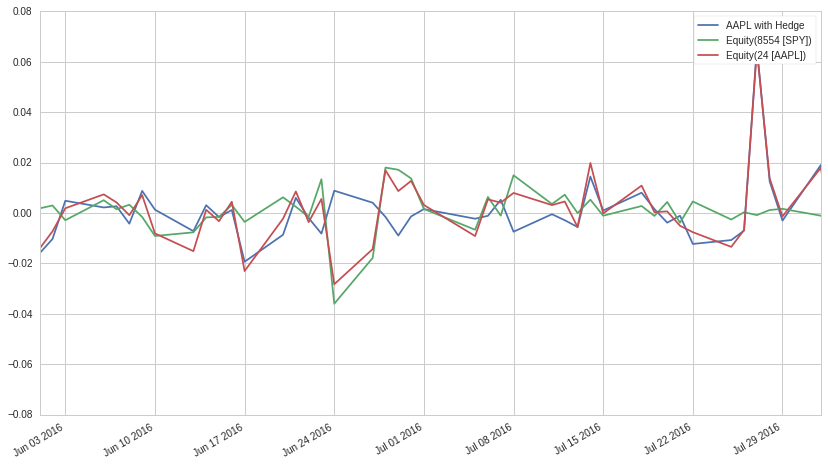

In [ ]:
hedged.plot(label='AAPL with Hedge')
bench_ret.plot()
asset_ret.plot()
plt.xlim(['2016-06-01','2016-08-01'])
plt.legend()

### Effects of Hedging

In [ ]:
def alpha_beta(benchmark_ret,stock):
    
    benchmark = sm.add_constant(benchmark_ret)
    
    model = regression.linear_model.OLS(stock,benchmark).fit()
    
    return model.params[0], model.params[1]

** 2016-2017 Alpha and Beta **

In [ ]:
# Get the alpha and beta estimates over the last year
start = '2016-01-01'
end = '2017-01-01'

asset2016 = get_pricing('AAPL', fields='price', start_date=start, end_date=end)
benchmark2016 = get_pricing('SPY', fields='price', start_date=start, end_date=end)

asset_ret2016 = asset2016.pct_change()[1:]
benchmark_ret2016 = benchmark2016.pct_change()[1:]

aret_val = asset_ret2016.values
bret_val = benchmark_ret2016.values

alpha2016, beta2016 = alpha_beta(bret_val,aret_val)

print('2016 Based Figures')
print('alpha: ' + str(alpha2016))
print('beta: ' + str(beta2016))

2016 Based Figures
alpha: 1.679902481e-05
beta: 1.02981369795


** Creating a Portfolio **

In [ ]:
# Create hedged portfolio and compute alpha and beta
portfolio = -1*beta2016*benchmark_ret2016 + asset_ret2016

alpha, beta = alpha_beta(benchmark_ret2016,portfolio)
print('Portfolio with Alphas and Betas:')
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

Portfolio with Alphas and Betas:
alpha: 1.679902481e-05
beta: 1.36609473733e-16


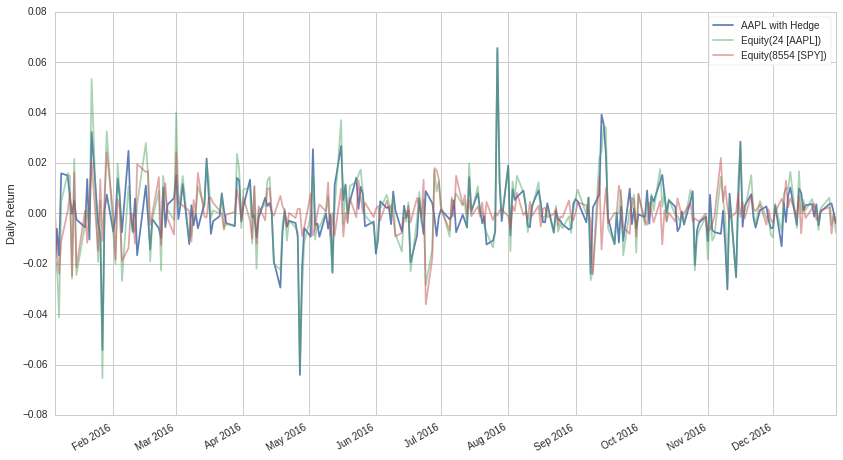

In [ ]:
# Plot the returns of the portfolio as well as the asset by itself
portfolio.plot(alpha=0.9,label='AAPL with Hedge')
asset_ret2016.plot(alpha=0.5);
benchmark_ret2016.plot(alpha=0.5)
plt.ylabel("Daily Return")
plt.legend();

In [ ]:
portfolio.mean()

1.6799024809993652e-05

In [ ]:
asset_ret2016.mean()

0.000574549568770769

In [ ]:
portfolio.std()

0.012065447808277703

In [ ]:
asset_ret2016.std()

0.014702747344261722

_____

** 2017 Based Figures **

In [ ]:
# Get data for a different time frame:
start = '2017-01-01'
end = '2017-08-01'

asset2017 = get_pricing('AAPL', fields='price', start_date=start, end_date=end)
benchmark2017 = get_pricing('SPY', fields='price', start_date=start, end_date=end)

asset_ret2017 = asset2017.pct_change()[1:]
benchmark_ret2017 = benchmark2017.pct_change()[1:]

aret_val = asset_ret2017.values
bret_val = benchmark_ret2017.values

alpha2017, beta2017 = alpha_beta(bret_val,aret_val)

print('2016 Based Figures')
print('alpha: ' + str(alpha2017))
print('beta: ' + str(beta2017))

2016 Based Figures
alpha: 0.000968854542346
beta: 1.26769880296


** Creating a Portfolio based off 2016 Beta estimate **

In [ ]:
# Create hedged portfolio and compute alpha and beta
portfolio = -1*beta2016*benchmark_ret2017 + asset_ret2017

alpha, beta = alpha_beta(benchmark_ret2017,portfolio)
print 'Portfolio with Alphas and Betas Out of Sample:'
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

Portfolio with Alphas and Betas Out of Sample:
alpha: 0.000968854542346
beta: 0.23788510501


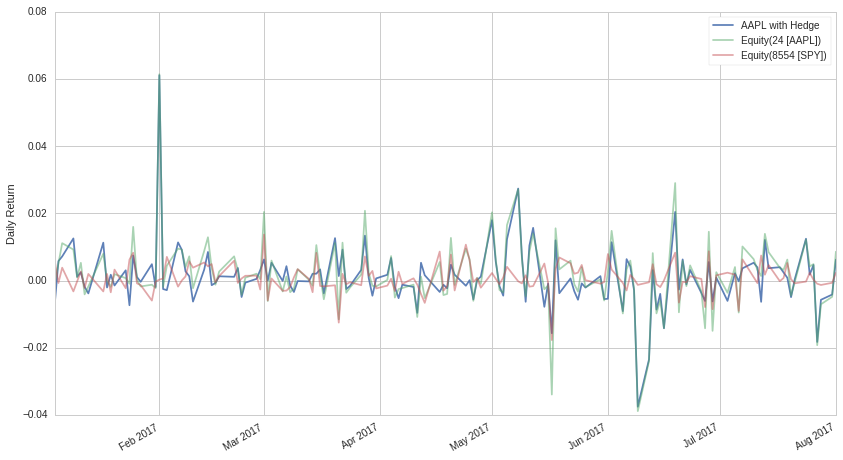

In [ ]:
# Plot the returns of the portfolio as well as the asset by itself
portfolio.plot(alpha=0.9,label='AAPL with Hedge')
asset_ret2017.plot(alpha=0.5);
benchmark_ret2017.plot(alpha=0.5)
plt.ylabel("Daily Return")
plt.legend();

What are the actual effects? Typically sacrificing average returns for less volatility, but this is also highly dependent on the security:

In [ ]:
portfolio.mean()

0.0011399935632582228

In [ ]:
asset_ret2017.mean()

0.0018808609159293456

In [ ]:
portfolio.std()

0.009066375411652783

In [ ]:
asset_ret2017.std()

0.010484461271996029

# Great Job!

# PyFolio Portfolio Analysis

In [ ]:
import pyfolio as pf
import matplotlib.pyplot as plt
import empyrical

## Set A Benchmark Algo for SPY

In [ ]:
def initialize(context):
    context.spy = sid(8554)

    
    set_max_leverage(1.01)
    
    schedule_function(rebalance,date_rules.every_day(),time_rules.market_open())
    
def rebalance(context,data):
    order_target_percent(context.spy,1)

In [ ]:
# Get benchmark returns
benchmark_rets = get_backtest('5986c511c94d014fc81acf7b')

100% Time: 0:00:00|###########################################################|


In [ ]:
bm_returns = benchmark_rets.daily_performance['returns']
bm_positions = benchmark_rets.pyfolio_positions
bm_transactions = benchmark_rets.pyfolio_transactions

### Use Algo from Leverage Lecture

In [ ]:
# Use same algo as in the Leverage Lecture!
bt = get_backtest('5986b969dbab994fa4264696')

100% Time: 0:00:00|###########################################################|


In [ ]:
bt_returns = bt.daily_performance['returns']
bt_positions = bt.pyfolio_positions
bt_transactions = bt.pyfolio_transactions

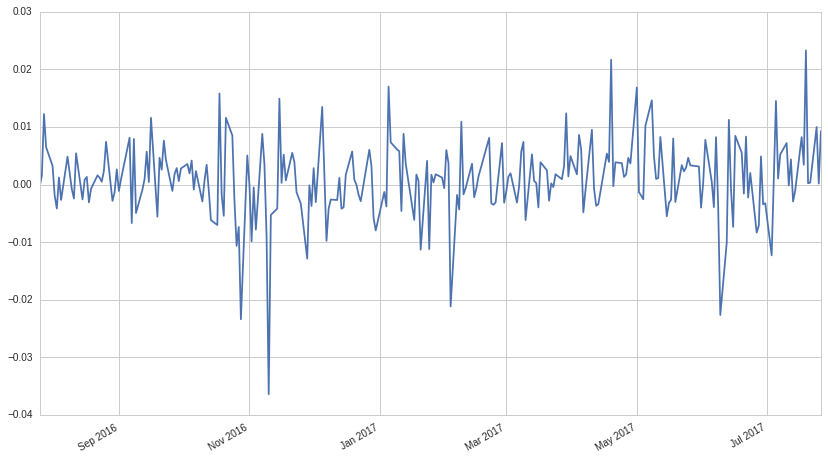

In [ ]:
bt_returns.plot()

In [ ]:
empyrical.beta(bt_returns,bm_returns)

0.14608838992380041

# PyFolio Plots

In [ ]:
benchmark_rets = bm_returns

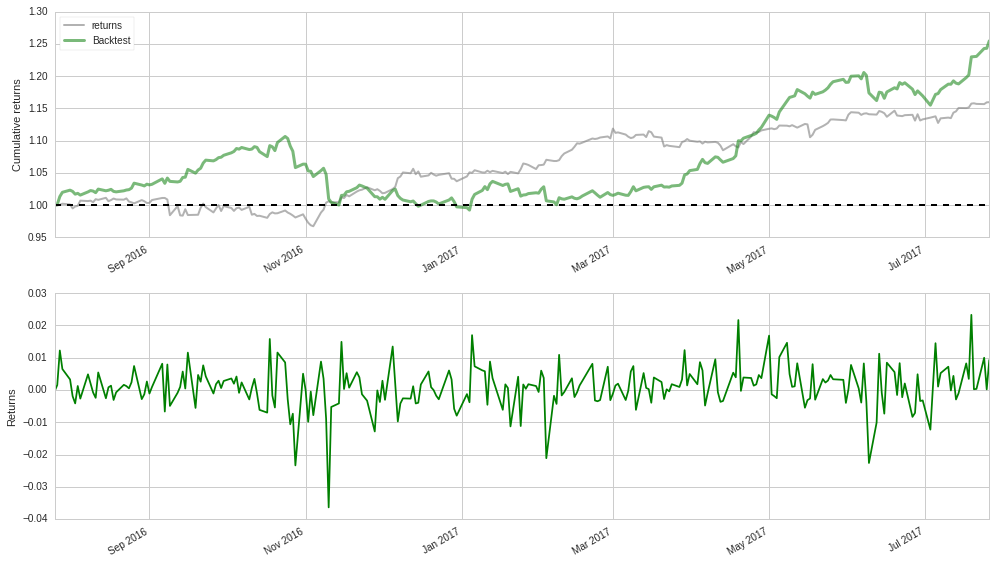

In [ ]:
# Cumulative Returns
plt.subplot(2,1,1)
pf.plotting.plot_rolling_returns(bt_returns, benchmark_rets)

# Daily, Non-Cumulative Returns
plt.subplot(2,1,2)
pf.plotting.plot_returns(bt_returns)
plt.tight_layout()

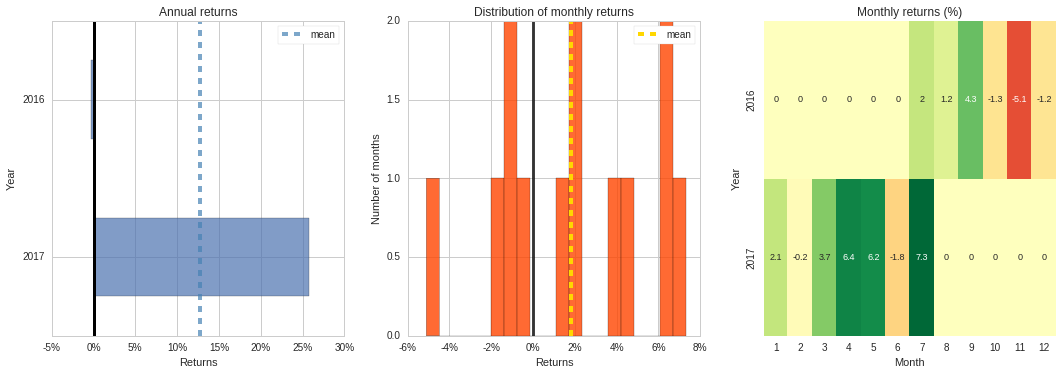

In [ ]:
fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(15,5)

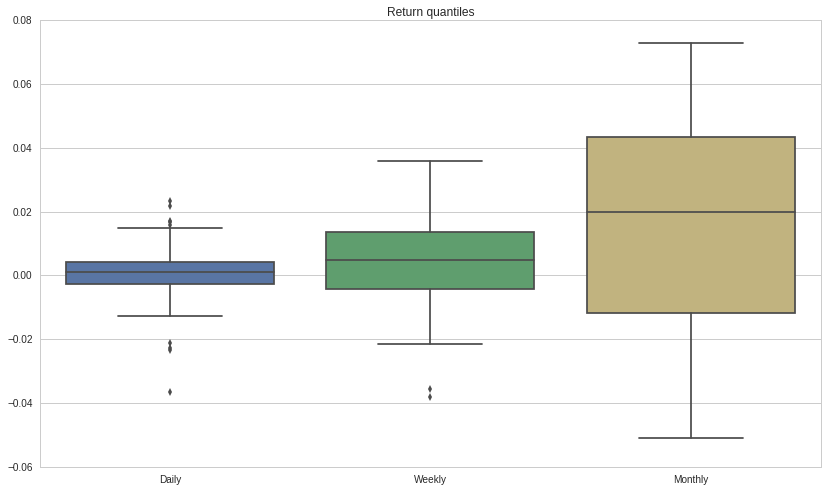

In [ ]:
pf.plot_return_quantiles(bt_returns);

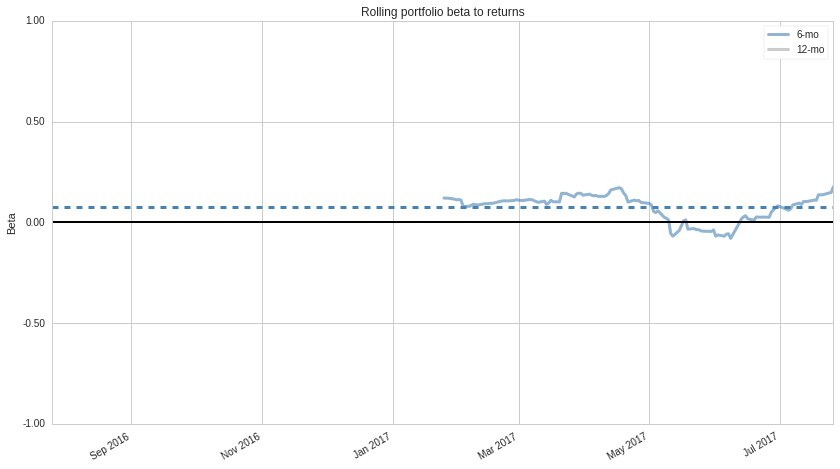

In [ ]:
pf.plot_rolling_beta(bt_returns, benchmark_rets);


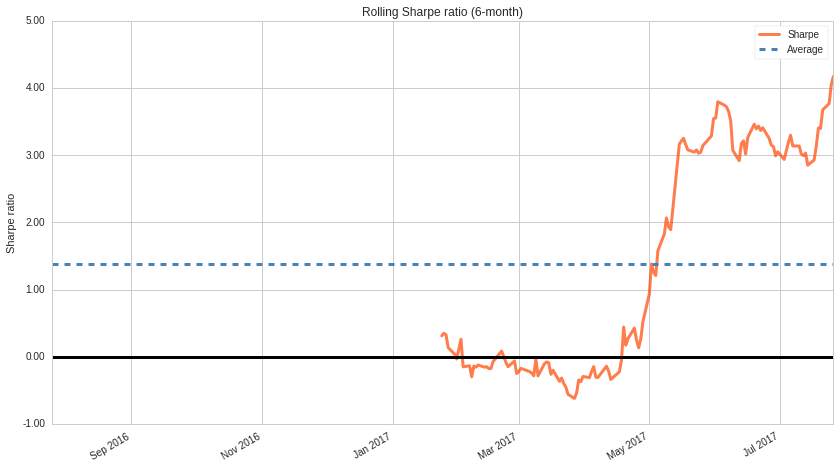

In [ ]:
pf.plot_rolling_sharpe(bt_returns);

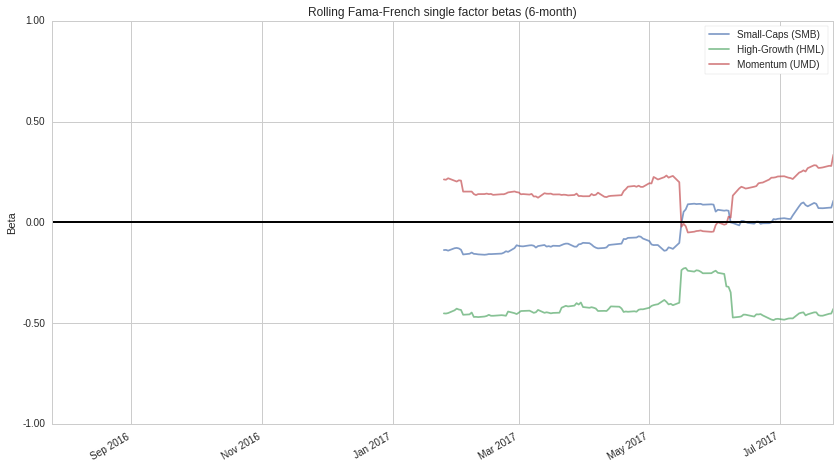

In [ ]:
pf.plot_rolling_fama_french(bt_returns);

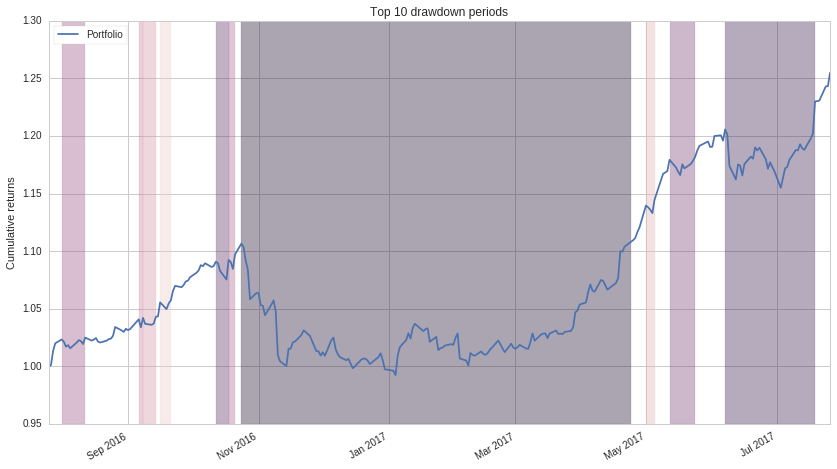

In [ ]:
pf.plot_drawdown_periods(bt_returns);

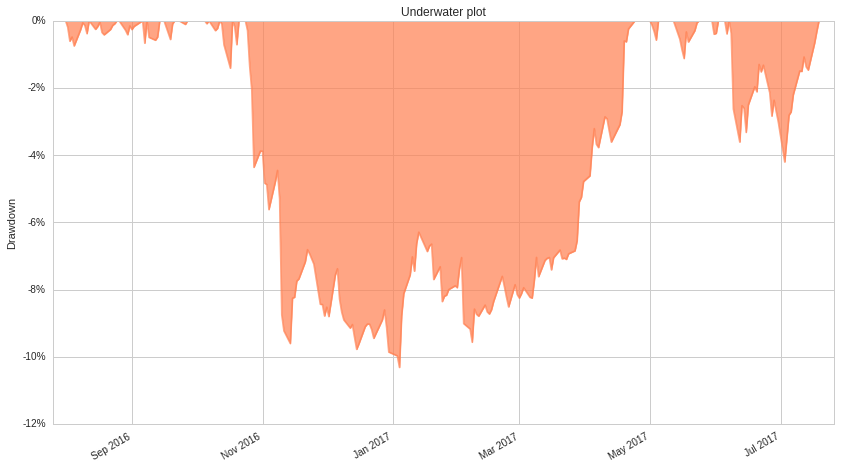

In [ ]:
pf.plot_drawdown_underwater(bt_returns);

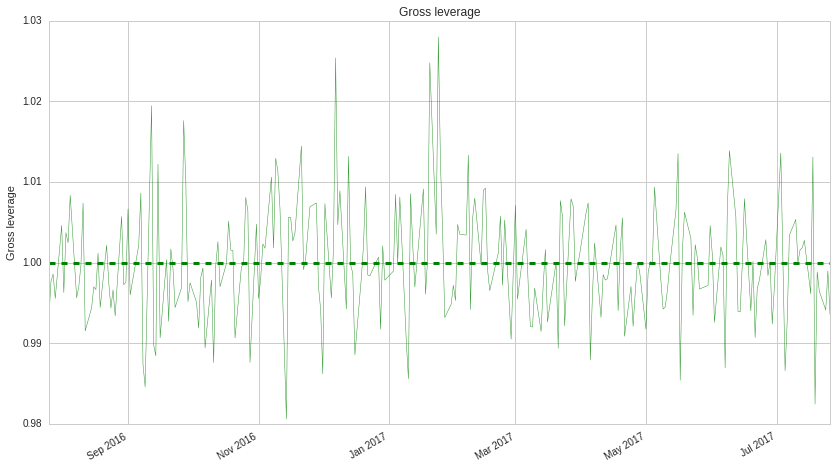

In [ ]:
pf.plot_gross_leverage(bt_returns, bt_positions);

Top 10 long positions of all time,max
AMZN-16841,50.93%


Top 10 short positions of all time,max
IBM-3766,-52.03%


Top 10 positions of all time,max
IBM-3766,52.03%
AMZN-16841,50.93%


All positions ever held,max
IBM-3766,52.03%
AMZN-16841,50.93%


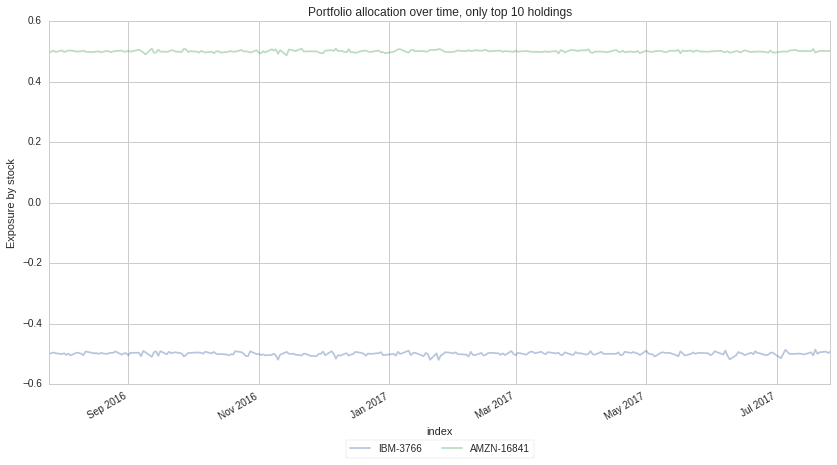

In [ ]:
pos_percent = pf.pos.get_percent_alloc(bt_positions)
pf.plotting.show_and_plot_top_positions(bt_returns, pos_percent);

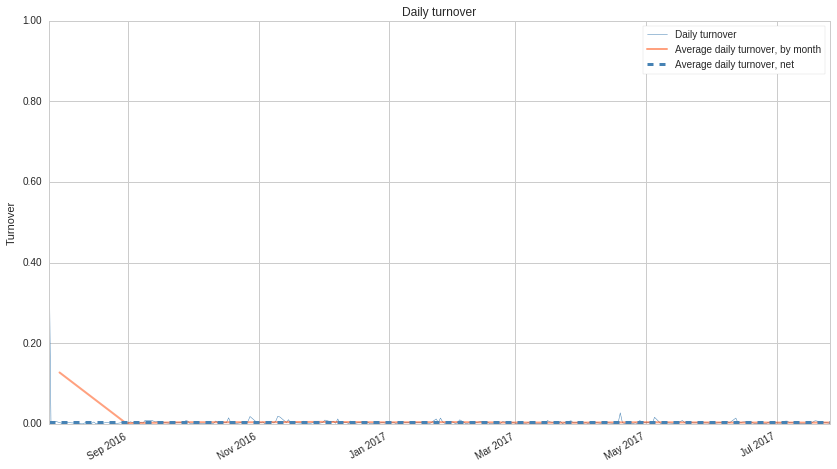

In [ ]:
pf.plot_turnover(bt_returns, bt_transactions, bt_positions);

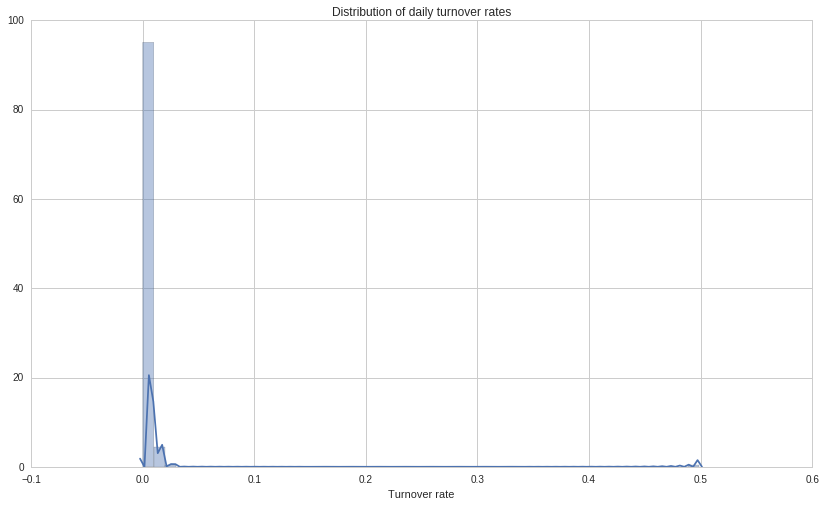

In [ ]:
pf.plotting.plot_daily_turnover_hist(bt_transactions, bt_positions);

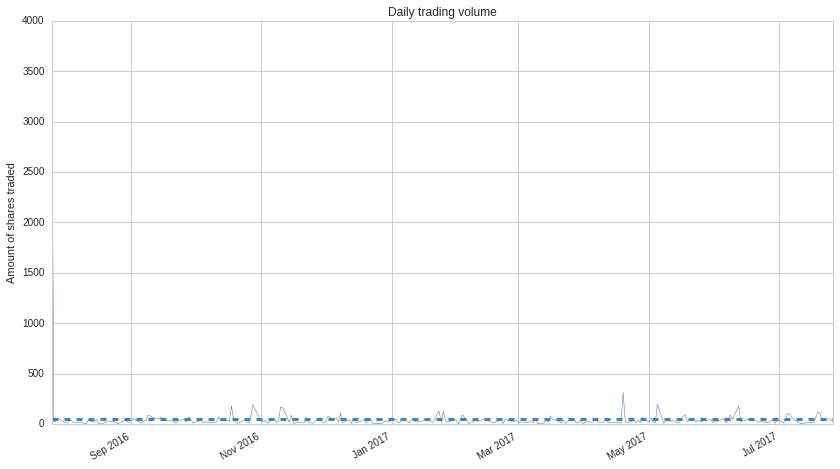

In [ ]:
pf.plotting.plot_daily_volume(bt_returns, bt_transactions);

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,231.00,105.00,126.00
Percent profitable,0.81,0.59,0.99
Winning round_trips,187.00,62.00,125.00
Losing round_trips,44.00,43.00,1.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$259314.80,$60829.40,$198485.40
Gross profit,$272619.52,$74125.78,$198493.74
Gross loss,$-13304.72,$-13296.38,$-8.34
Profit factor,$20.49,$5.57,$23797.26
Avg. trade net profit,$1122.57,$579.33,$1575.28
Avg. winning trade,$1457.86,$1195.58,$1587.95
Avg. losing trade,$-302.38,$-309.22,$-8.34
Ratio Avg. Win:Avg. Loss,$4.82,$3.87,$190.38
Largest winning trade,$151212.26,$61139.59,$151212.26
Largest losing trade,$-1626.13,$-1626.13,$-8.34


Duration stats,All trades,Short trades,Long trades
Avg duration,178 days 01:22:27.536796,174 days 20:37:58.866666,180 days 17:19:31.428571
Median duration,182 days 01:00:00,170 days 01:00:00,184 days 13:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.09%,0.05%,0.13%
Avg returns winning,0.12%,0.10%,0.13%
Avg returns losing,-0.03%,-0.03%,-0.00%
Median returns all round_trips,0.01%,0.00%,0.02%
Median returns winning,0.02%,0.01%,0.02%
Median returns losing,-0.02%,-0.02%,-0.00%
Largest winning trade,12.16%,4.92%,12.16%
Largest losing trade,-0.16%,-0.16%,-0.00%


Symbol stats,AMZN-16841,IBM-3766
Avg returns all round_trips,0.13%,0.05%
Avg returns winning,0.13%,0.10%
Avg returns losing,-0.00%,-0.03%
Median returns all round_trips,0.02%,0.00%
Median returns winning,0.02%,0.01%
Median returns losing,-0.00%,-0.02%
Largest winning trade,12.16%,4.92%
Largest losing trade,-0.00%,-0.16%


Profitability (PnL / PnL total) per name,pnl
AMZN-16841,0.77%
IBM-3766,0.23%


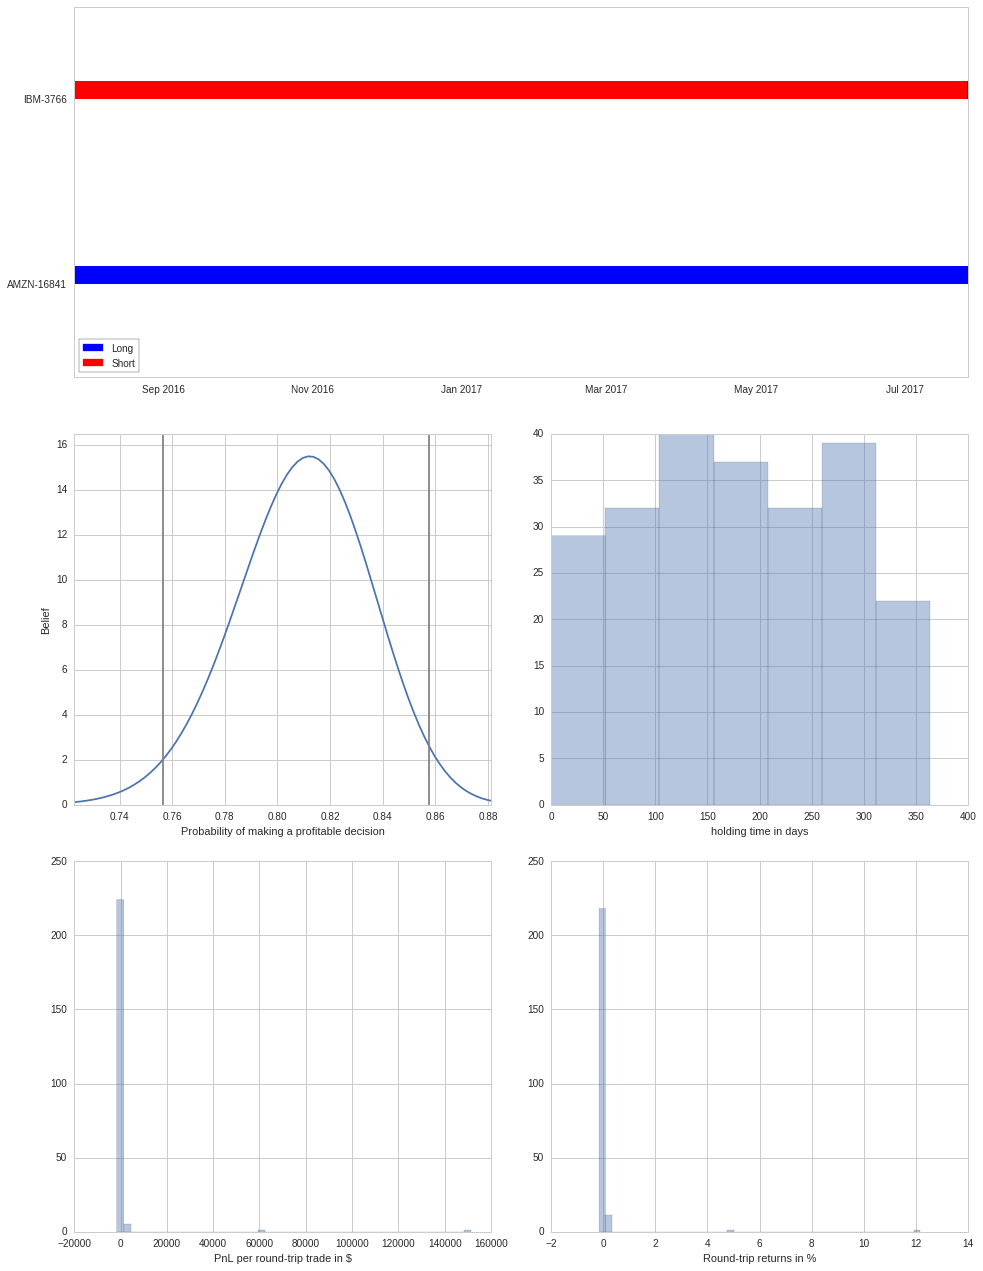

In [ ]:
pf.create_round_trip_tear_sheet(bt_returns, bt_positions, bt_transactions);

# Stock Sentiment Analysis

Check out the video for full details.

## Final Code
Here is the final code:

In [ ]:
# This section is only importable in the backtester
from quantopian.algorithm import attach_pipeline, pipeline_output

# General pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import AverageDollarVolume


# Using the free sample in your pipeline algo
from quantopian.pipeline.data.accern import alphaone_free


def initialize(context):
    # Schedule our rebalance function to run at the start of each week.
    schedule_function(my_rebalance, date_rules.every_day())

    
    attach_pipeline(make_pipeline(), "pipeline")

def make_pipeline():

    
    # Screen out penny stocks and low liquidity securities.
    dollar_volume = AverageDollarVolume(window_length=20)
    is_liquid = dollar_volume.rank(ascending=False) < 1000
 
    # Add pipeline factors
    impact = alphaone_free.impact_score.latest
    sentiment = alphaone_free.article_sentiment.latest

    return Pipeline(columns={
            'impact': impact,
            'sentiment':sentiment,
            },
            screen = is_liquid)
            


    
def before_trading_start(context, data):
    port = pipeline_output('pipeline')
    
    # Grab stocks with 100 impact and >0.5 sentiment and go long.
    context.longs = port[(port['impact']==100) & (port['sentiment']>0.75)].index.tolist()
    
    # Grab stocks with 100 impact and <-0.5 sentiment and go long.
    context.shorts = port[(port['impact']==100) & (port['sentiment']< -0.75)].index.tolist()

    context.long_weight, context.short_weight = my_compute_weights(context)

def my_compute_weights(context):

    # Compute even target weights for our long positions and short positions.
    long_weight = 0.5 / len(context.longs)
    short_weight = -0.5 / len(context.shorts)

    return long_weight, short_weight

def my_rebalance(context, data):

    for security in context.portfolio.positions:
        if security not in context.longs and security not in context.shorts and data.can_trade(security):
            order_target_percent(security, 0)

    for security in context.longs:
        if data.can_trade(security):
            order_target_percent(security, context.long_weight)

    for security in context.shorts:
        if data.can_trade(security):
            order_target_percent(security, context.short_weight)
    
    
    

    


# Futures

Extra Resources: 

* https://en.wikipedia.org/wiki/Futures_contract
* http://www.investopedia.com/terms/f/futurescontract.asp

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Getting Futures

A reference to a futures contract is obtained via the symbols function. Futures contracts are denoted by a base symbol + a code for month/year of delivery. CLF16 is a contract for crude oil (CL) with delivery in January (F) 2016 (16).

### List of all Available Futures (on Quantopian)

Symbol | Future |
--- | --- | 
BD | Big Dow
BO | Soybean Oil
CM | Corn E-Mini
CN | Corn
DJ | DJIA Futures
ET | Ethanol
FF | 30-Day Federal Funds
FI | 5-Year Deliverable Interest Rate Swap Futures
FS | 5-Year Interest Rate Swap Futures
FV | 5-Year T-Note
MB | Municipal Bonds
MS | Soybeans E-Mini
MW | Wheat E-Mini
OA | Oats
RR | Rough Rice
SM | Soybean Meal
SY | Soybeans
TN | 10-Year Deliverable Interest Rate Swap Futures
TS | 10-Year Interest Rate Swap Futures
TU | 2-Year T-Note
TY | 10-Year T-Note
UB | Ultra Tbond
US | 30-Year T-Bond
WC | Wheat
YM | Dow Jones E-mini
VX | VIX Futures
AD | Australian Dollar
AI | Bloomberg Commodity Index Futures
BP | British Pound
CD | Canadian Dollar
EC | Euro FX
ED | Eurodollar
EE | Euro FX E-mini
ES | S&P 500 E-Mini
EU | E-micro EUR/USD Futures
FC | Feeder Cattle
JE | Japanese Yen E-mini
JY | Japanese Yen
LB | Lumber
LC | Live Cattle
LH | Lean Hogs
MD | S&P 400 MidCap Futures
ME | Mexican Peso
MI | S&P 400 MidCap E-Mini
ND | NASDAQ 100 Futures
NK | Nikkei 225 Futures
NQ | NASDAQ 100 E-Mini
NZ | New Zealand Dollar
SF | Swiss Franc
SP | S&P 500 Futures
TB | TBills
GC | Gold
HG | Copper High Grade
SV | Silver
CL | Light Sweet Crude Oil
HO | NY Harbor ULSD Futures
HU | Unleaded Gasoline
NG | Natural Gas
PA | Palladium
PL | Platinum
PB | Pork Bellies
QG | Natural Gas E-mini
QM | Crude Oil E-Mini
XB | RBOB Gasoline Futures
EI | MSCI Emerging Markets Mini
EL | Eurodollar NYSE LIFFE
MG | MSCI EAFE Mini
XG | Gold mini-sized
YS | Silver mini-sized
RM | Russell 1000 Mini
SB | Sugar #11
ER | Russell 2000 Mini

## List of Date/Time Codes

Month | Code |
--- | --- | 
January | F
February | G
March | H
April | J
May | K
June | M
July | N
August | Q
September | U
October | V
November | X
December | Z

Let's grab the future contract data for Natural Gas for a maturity date of January 2018. (If you are viewing this lecture some time in the future, choose a further out maturity date)

In [ ]:
future_contract = symbols('NGF18')

In [ ]:
future_contract.asset_name

u'Natural Gas'

In [ ]:
for key in future_contract.to_dict():
    print(key)
    print(future_contract.to_dict()[key])
    print('\n')

root_symbol
NG


tick_size
0.001


end_date
2017-08-08 00:00:00+00:00


exchange
NYMEX


auto_close_date
2017-12-22 00:00:00+00:00


expiration_date
2017-12-27 00:00:00+00:00


symbol
NGF18


multiplier
10000.0


notice_date
2017-12-28 00:00:00+00:00


first_traded
None


asset_name
Natural Gas


exchange_full
NYMEX


sid
1061201801


start_date
2010-08-24 00:00:00+00:00




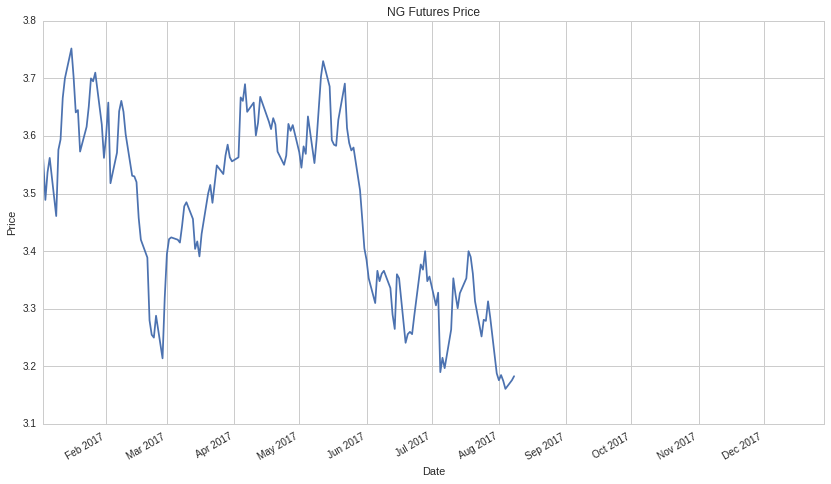

In [ ]:
futures_position_value = get_pricing(future_contract, start_date = '2017-01-01', end_date = '2018-01-01', fields = 'price')
futures_position_value.name = futures_position_value.name.symbol
futures_position_value.plot()
plt.title('NG Futures Price')
plt.xlabel('Date')
plt.ylabel('Price');

## Historical Data

In [ ]:
from quantopian.research.experimental import history

In [ ]:
print history.__doc__


    Load a table of historical trade data.

    Parameters
    ----------
    symbols : Asset-convertible object, ContinuousFuture, or iterable of same.
        Valid input types are Asset, Integral, basestring, or ContinuousFuture.
        In the case that the passed objects are strings, they are interpreted
        as ticker symbols and resolved relative to the date specified by
        symbol_reference_date.

    fields : str or list, optional
        String or list drawn from {'price', 'open_price', 'high', 'low',
        'close_price', 'volume', 'contract'}. Defaults to 'close_price'.

    frequency : {'daily', 'minute'}, optional
        Resolution of the data to be returned. Defaults to 'daily'.

    start_date : str or pd.Timestamp, optional
        String or Timestamp representing a start date or start intraday minute
        for the returned data. Defaults to '2013-01-03'.

    end_date : str or pd.Timestamp, optional
        String or Timestamp representing an end date or e

In [ ]:
ngf18 = future_contract

In [ ]:
ngf18_data = history(ngf18, 
                     fields=['price', 'open_price', 'high', 'low', 'close_price', 'volume', 'contract'], 
                     frequency='daily', 
                     start_date='2017-06-01', 
                     end_date='2017-08-01')

ngf18_data.head()

,price,open_price,high,low,close_price,volume,contract
2017-06-01 00:00:00+00:00,3.385,3.412,3.435,3.341,3.385,5497.0,Future(1061201801 [NGF18])
2017-06-02 00:00:00+00:00,3.353,3.386,3.386,3.336,3.353,2443.0,Future(1061201801 [NGF18])
2017-06-05 00:00:00+00:00,3.310,3.373,3.378,3.298,3.310,2457.0,Future(1061201801 [NGF18])
2017-06-06 00:00:00+00:00,3.366,3.318,3.371,3.307,3.366,2061.0,Future(1061201801 [NGF18])
2017-06-07 00:00:00+00:00,3.348,3.370,3.393,3.342,3.348,1834.0,Future(1061201801 [NGF18])


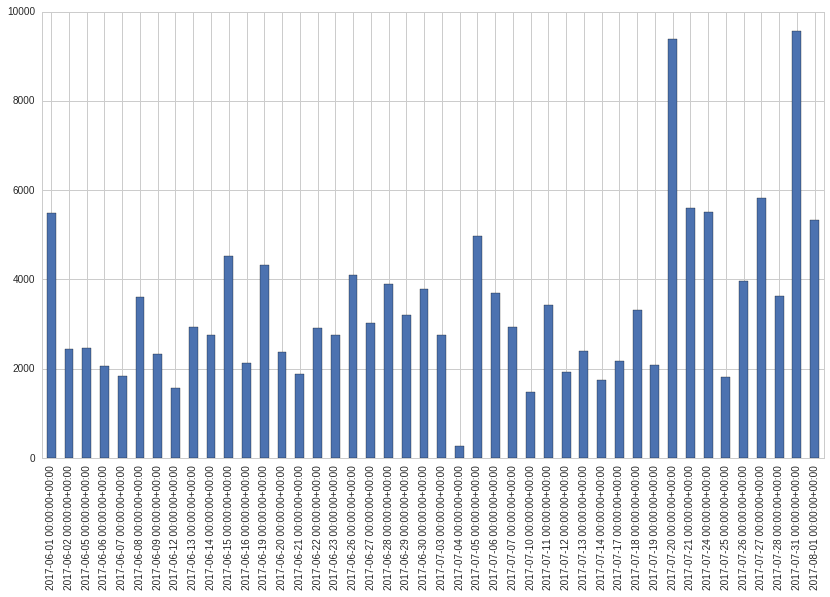

In [ ]:
# Notice the 4th of July!
ngf18_data['volume'].plot(kind='bar')

## Comparison of Different Maturity Dates

In [ ]:
ng_contracts = symbols(['NGF17', 'NGG17', 'NGH17', 'NGJ17', 'NGK17', 'NGM17'])

In [ ]:
ng_consecutive_contract_volume = history(ng_contracts, 
                                         fields='volume', 
                                         frequency='daily', 
                                         start_date='2016-01-01', 
                                         end_date='2017-08-01')

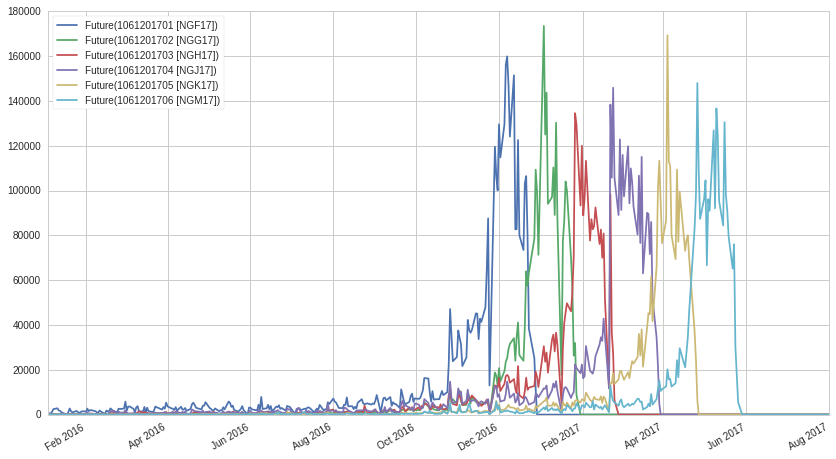

In [ ]:
ng_consecutive_contract_volume.plot()

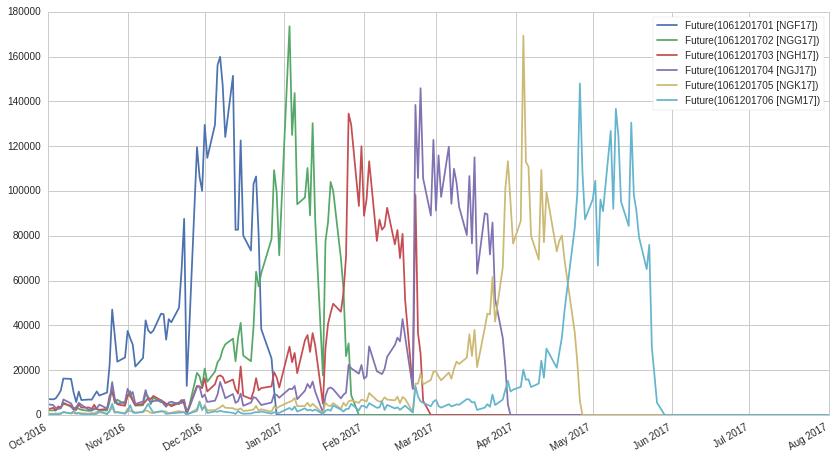

In [ ]:
ng_consecutive_contract_volume.plot(xlim=['2016-10-01','2017-08-01'])

Trading activity jumps from one contract to the next. Transitions happen just prior to the delivery date of each contract.

This phenomenon can make it difficult to work with futures. Having to explicitly reference a series of transient contracts when trading or simulating futures can be a hassle.

In order to trade consecutive contracts for the same underlying future, we can use what's called a "Continuous Future".

# Continuous Futures

Continuous futures are abstractions over the 'underlying' commodities/assets/indexes of futures. For example, if we wanted to trade crude oil, we could create a reference to CL, instead of a series of CL contracts. Continuous futures essentially maintain a reference to a 'current' contract deemed to be the active contract for the particular underlying.

We use the continuous futures objects as part of the platform to get a continuous chain of historical data for futures contracts, taking these concerns into account. There are several ways to adjust for the cost of carry when looking at historical data, though people differ on what they prefer. The general consensus is that an adjustment should be done.

Continuous futures are not tradable assets. They maintain a reference to the current active contract related to a given underlying.

In [ ]:
from quantopian.research.experimental import continuous_future

In [ ]:
print(continuous_future.__doc__)


    Create a specifier for a continuous contract.

    Parameters
    ----------
    root_symbol : str
        The root symbol for the continuous future.

    offset : int, optional
        The distance from the primary contract. Default is 0.

    roll : str, optional
        How rolls are determined. Options are 'volume' and 'calendar'. Default
        is 'volume'.

    adjustment : str
        Method for adjusting lookback prices between rolls. Options are
        'mul', 'add', and None. Default is 'mul'.

    Returns
    -------
    continuous_future : ContinuousFuture
        The continuous future specifier.
    


There are 4 arguments that we need to consider.

- **`root_symbol`**: The root symbol of the underlying. For example, 'CL' for crude oil.
- **`offset`**: The distance from the primary contract. 0 = primary, 1 = secondary, etc. We'll get into this more later.
- **`roll`**: How to determine the 'current' contract of the continuous future. Current options are **`'volume'`** and **`'calendar'`**. The 'volume' approach chooses the current active contract based on trading volume. The 'calendar' approach chooses the current active contract based simply on the `auto_close_date`s of each contract.**
- **`adjustment`**: How to adjust historical prices from earlier contracts. We'll get into this more later. Options are **`'mul'`**, **`'add'`**, or **`'None'`**.

In [ ]:
continuous_ng = continuous_future('NG', offset=0, roll='volume', adjustment='mul')

In [ ]:
continuous_ng

ContinuousFuture(94090707563773952, root_symbol='NG', offset=0, roll_style='volume', adjustment='mul')

In [ ]:
ng_cont_active = history(continuous_ng, 
                    fields=['contract','price','volume'] ,
                    frequency='daily', 
                    start_date='2016-10-01', 
                    end_date='2017-08-01')

In [ ]:
ng_cont_active.head()

,price,volume,contract
2016-10-03 00:00:00+00:00,4.067,86282.0,Future(1061201611 [NGX16])
2016-10-04 00:00:00+00:00,4.161,90845.0,Future(1061201611 [NGX16])
2016-10-05 00:00:00+00:00,4.245,119522.0,Future(1061201611 [NGX16])
2016-10-06 00:00:00+00:00,4.251,135372.0,Future(1061201611 [NGX16])
2016-10-07 00:00:00+00:00,4.438,159697.0,Future(1061201611 [NGX16])


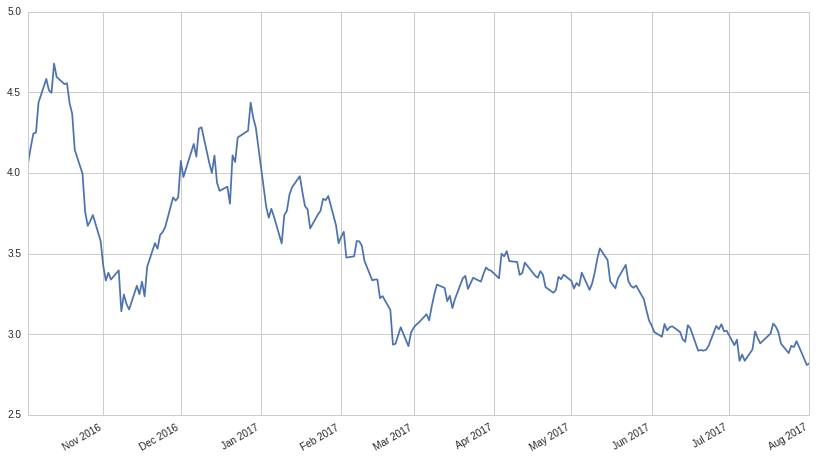

In [ ]:
ng_cont_active['price'].plot()

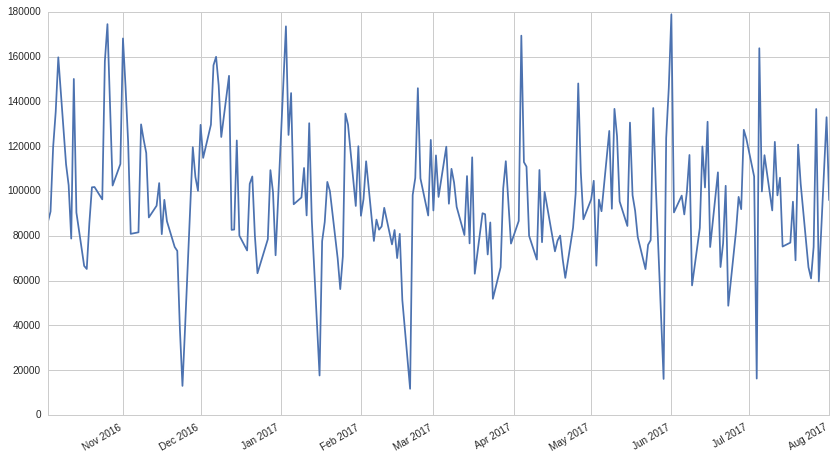

In [ ]:
ng_cont_active['volume'].plot()

In [ ]:
ng_consecutive_contract_volume = history(ng_contracts, 
                                         fields='volume', 
                                         frequency='daily', 
                                         start_date='2016-10-01', 
                                         end_date='2017-08-01')

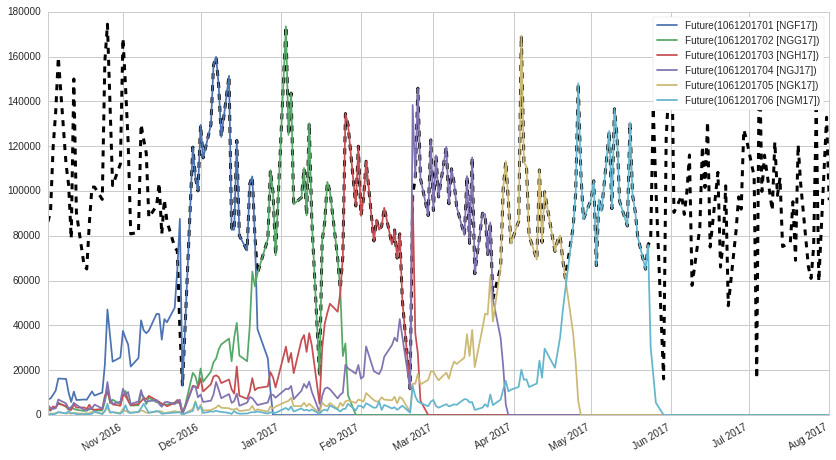

In [ ]:
ax = ng_cont_active['volume'].plot(ls='--',c='black',lw=3)
ng_consecutive_contract_volume.plot(ax=ax)

In [ ]:
ng_consecutive_contract_price = history(ng_contracts, 
                                         fields='price', 
                                         frequency='daily', 
                                         start_date='2016-10-01', 
                                         end_date='2017-08-01')

In [ ]:
ng_continuous_active = history(continuous_ng, 
                    fields=['contract','price','volume'] ,
                    frequency='daily', 
                    start_date='2016-10-01', 
                    end_date='2017-08-01')

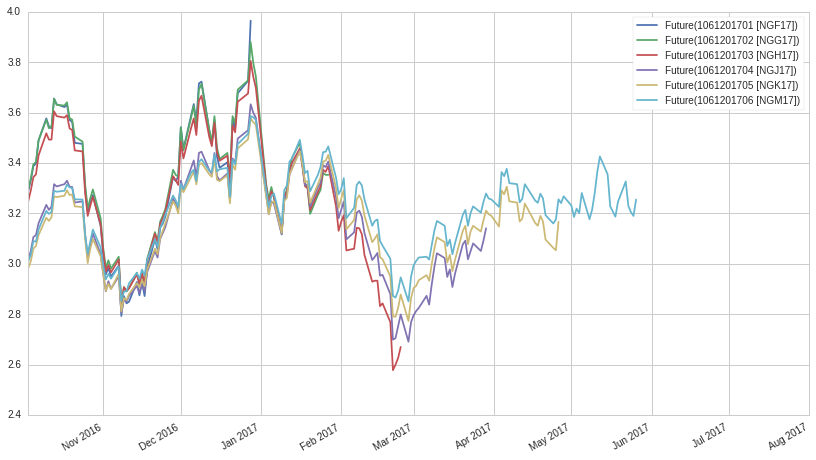

In [ ]:
ng_consecutive_contract_price.plot()

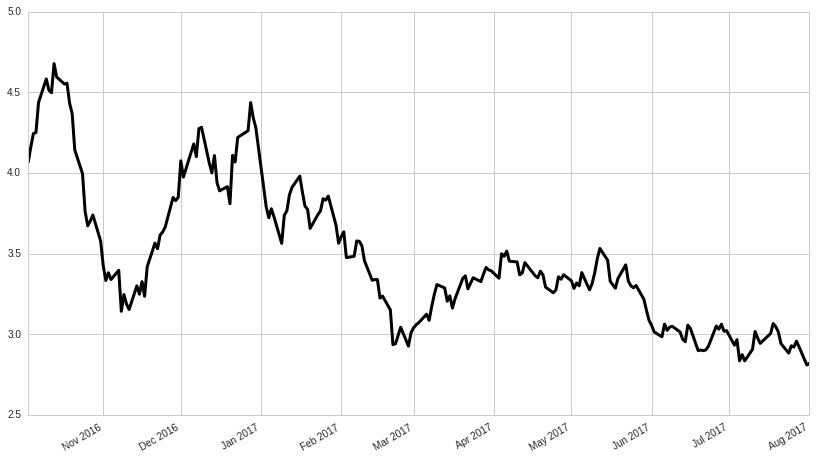

In [ ]:
ng_cont_active['price'].plot(c='black',lw=3)

This represents the price of the underlying commodity, NG, on the most actively traded contract. Much easier to look at.

You might notice that the price at the start of this plot exceeds 4.0, but when we plotted the individual contracts, it barely made it above 3.6. This is because the historical price is getting adjusted for jumps between contracts.

The best way to explain this is to plot the prices history of the unadjusted continuous future.

In [ ]:
continuous_ng_unadjusted = continuous_future('NG', offset=0, roll='volume', adjustment=None)

In [ ]:
ng_unadjusted_history = history(continuous_ng_unadjusted, 
                                fields=['contract', 'price'], 
                                frequency='daily', 
                                start_date='2016-10-01', 
                                end_date='2017-08-01')

In [ ]:
ng_unadjusted_history.head()

,price,contract
2016-10-03 00:00:00+00:00,2.906,Future(1061201611 [NGX16])
2016-10-04 00:00:00+00:00,2.973,Future(1061201611 [NGX16])
2016-10-05 00:00:00+00:00,3.033,Future(1061201611 [NGX16])
2016-10-06 00:00:00+00:00,3.037,Future(1061201611 [NGX16])
2016-10-07 00:00:00+00:00,3.171,Future(1061201611 [NGX16])


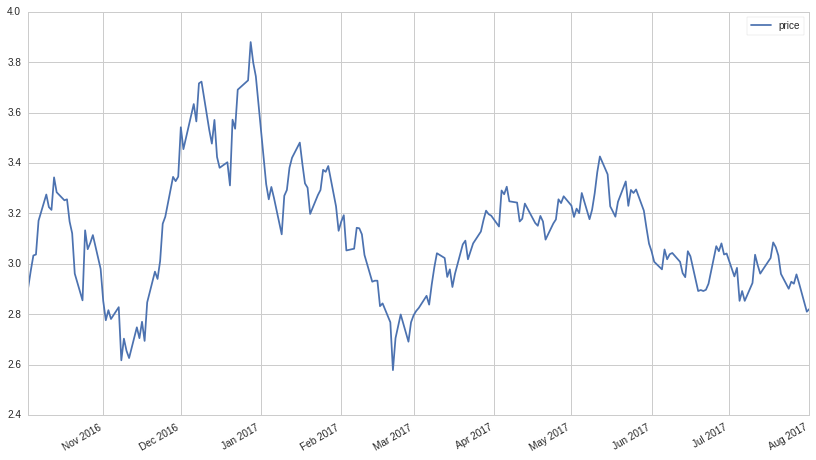

In [ ]:
ng_unadjusted_history.plot()

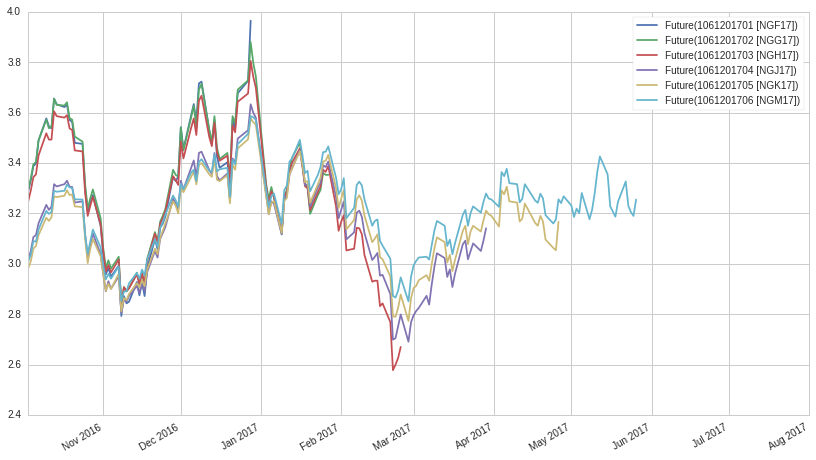

In [ ]:
ng_consecutive_contract_price.plot()

In [ ]:
pivot_unadj = ng_unadjusted_history.pivot(index=ng_unadjusted_history.index,columns='contract')

In [ ]:
pivot_unadj.head()

price  \
contract                  Future(1061201611 [NGX16])   
2016-10-03 00:00:00+00:00                      2.906   
2016-10-04 00:00:00+00:00                      2.973   
2016-10-05 00:00:00+00:00                      3.033   
2016-10-06 00:00:00+00:00                      3.037   
2016-10-07 00:00:00+00:00                      3.171   

                                                      \
contract                  Future(1061201612 [NGZ16])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201701 [NGF17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201702 [NGG17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201703 [NGH17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201704 [NGJ17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201705 [NGK17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201706 [NGM17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201707 [NGN17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      \
contract                  Future(1061201708 [NGQ17])   
2016-10-03 00:00:00+00:00                        NaN   
2016-10-04 00:00:00+00:00                        NaN   
2016-10-05 00:00:00+00:00                        NaN   
2016-10-06 00:00:00+00:00                        NaN   
2016-10-07 00:00:00+00:00                        NaN   

                                                      
contract                  Future(1061201709 [NGU17])  
2016-10

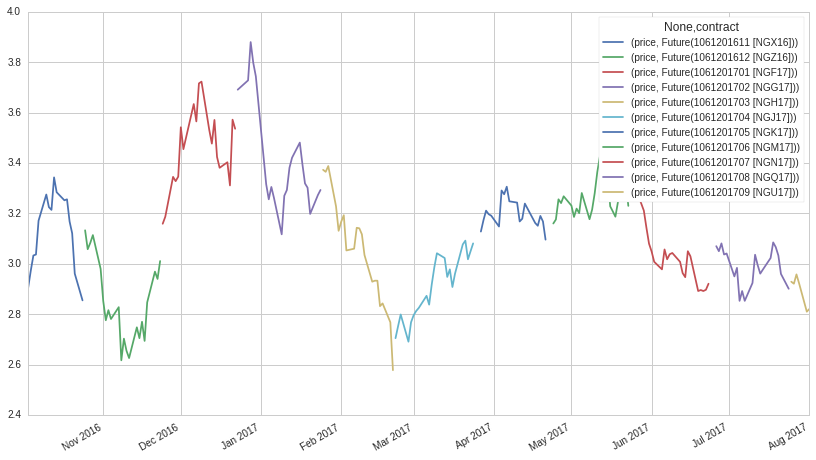

In [ ]:
pivot_unadj.plot()

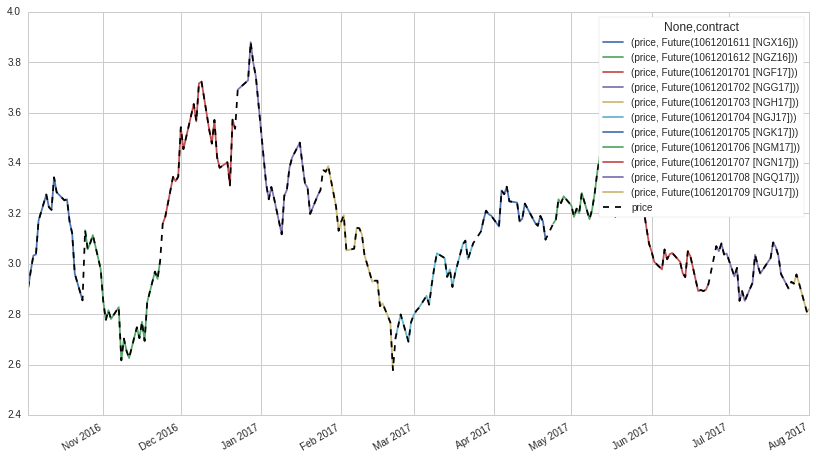

In [ ]:
ax = pivot_unadj.plot()
ng_unadjusted_history.plot(ax=ax,ls='--',c='black')

## Adjustment Types

There are two main adjustment types, additive or multiplicative.

* Multiplicative adjustment, mul

This essentially computes the adjustment as the ratio of new contract price / old contract price whenever the active contract rolls to a new contract.

* Arithmetic adjustment, 'add'

The 'add' technique computes the adjustment as the difference new contract price - old contract price.